In [1]:
import sys, os
import numpy as np
import pandas as pd
import random
from random import shuffle, choice
import time
import os
import glob
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from random import shuffle, choice
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler,StandardScaler

batch_size = 250
epochs = 100
epochs_traits = 500
num_classes = 3

class LinearW(Layer):

    def __init__(self):
        super(LinearW, self).__init__()
        
    def build(self, input_shape):

        self.W = self.add_weight(name='name',
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

def create_mlp(traitstrain, regularizer=None):
  """Creates a three-layer MLP with inputs of the given dimension"""
  model = Sequential()
  model.add(Dense(150, use_bias=False, input_dim=traitstrain.shape[1], activation="relu", kernel_regularizer=regularizers.l1(0.001)))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(150, use_bias=False, activation="relu"))
  model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation="relu"))
  return model

def create_cnn(xtest, regularizer=None):
  inputShape = (xtest.shape[1], xtest.shape[2])
  inputs = Input(shape=inputShape)
  x = inputs
  x = Conv1D(250, kernel_size=3, activation='relu', use_bias=False, input_shape=(xtest.shape[1], xtest.shape[2]))(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv1D(250, kernel_size=3, use_bias=False, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=3)(x)
  x = Flatten()(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(125, activation='relu')(x)
  x = Dropout(0.5)(x)
  # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
  x = Dense(50, kernel_regularizer=regularizer)(x)
  x = Activation("relu")(x)
  # Construct the CNN
  model = Model(inputs, x)
  # Return the CNN
  return model

2023-03-20 13:27:38.638698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:27:38.750672: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
traits_BM = []
traits_BM = np.loadtxt("./traits/traits_BM.txt").reshape(30000,-1,100)
traits_BM = np.array(traits_BM)

#Standard scale the continuous traits
scalers_BM = {}
for i in range(traits_BM.shape[2]):
    scalers_BM[i] = StandardScaler(copy=False)
    traits_BM[:, :, i] = scalers_BM[i].fit_transform(traits_BM[:, :, i]) 

Traits_BM = np.array(traits_BM)

u1 = np.load("./trainingSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./trainingSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./trainingSims/Model_3sp.npz",mmap_mode='r')

u=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(u):
    for idx,row in enumerate(array):
        if np.count_nonzero(row) > len(row)/2:
            u[arr][idx][u[arr][idx] == 1] = -1
            u[arr][idx][u[arr][idx] == 0] = 1
        else:
            u[arr][idx][u[arr][idx] == 0] = -1


In [3]:
################################################################################################################################################
#20% Missing Data SNPs
################################################################################################################################################
X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


2023-03-15 17:42:51.564962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 17:42:52.198078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21876 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 998, 250)     45000       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 998, 250)    1000        ['conv1d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_1 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_2[0][

2023-03-15 17:42:57.643322: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-15 17:42:57.838700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-15 17:42:59.348112: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 17:42:59.349727: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 17:42:59.349742: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-15 17:42:59.351568: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 17:42:59.351622: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

90/90 [==============================] - 17s 119ms/step - loss: 10.8861 - accuracy: 0.4186 - val_loss: 10.8265 - val_accuracy: 0.4744
Epoch 2/100
90/90 [==============================] - 9s 105ms/step - loss: 10.6627 - accuracy: 0.5477 - val_loss: 10.6499 - val_accuracy: 0.6299
Epoch 3/100
90/90 [==============================] - 10s 117ms/step - loss: 10.5059 - accuracy: 0.6222 - val_loss: 10.4321 - val_accuracy: 0.7073
Epoch 4/100
90/90 [==============================] - 11s 118ms/step - loss: 10.3750 - accuracy: 0.6789 - val_loss: 10.2298 - val_accuracy: 0.7613
Epoch 5/100
90/90 [==============================] - 10s 112ms/step - loss: 10.2603 - accuracy: 0.7185 - val_loss: 10.0586 - val_accuracy: 0.8485
Epoch 6/100
90/90 [==============================] - 10s 113ms/step - loss: 10.1379 - accuracy: 0.7634 - val_loss: 9.9254 - val_accuracy: 0.8875
Epoch 7/100
90/90 [==============================] - 10s 110ms/step - loss: 10.0243 - accuracy: 0.8014 - val_loss: 9.8090 - val_accuracy: 

Epoch 58/100
90/90 [==============================] - 10s 109ms/step - loss: 7.6363 - accuracy: 0.9960 - val_loss: 7.6055 - val_accuracy: 0.9985
Epoch 59/100
90/90 [==============================] - 10s 107ms/step - loss: 7.6036 - accuracy: 0.9940 - val_loss: 7.5693 - val_accuracy: 0.9988
Epoch 60/100
90/90 [==============================] - 10s 106ms/step - loss: 7.5663 - accuracy: 0.9952 - val_loss: 7.5342 - val_accuracy: 0.9984
Epoch 61/100
90/90 [==============================] - 10s 106ms/step - loss: 7.5303 - accuracy: 0.9952 - val_loss: 7.4997 - val_accuracy: 0.9983
Epoch 62/100
90/90 [==============================] - 10s 106ms/step - loss: 7.4926 - accuracy: 0.9958 - val_loss: 7.4635 - val_accuracy: 0.9984
Epoch 63/100
90/90 [==============================] - 9s 105ms/step - loss: 7.4605 - accuracy: 0.9946 - val_loss: 7.4286 - val_accuracy: 0.9979
Epoch 64/100
90/90 [==============================] - 10s 106ms/step - loss: 7.4227 - accuracy: 0.9959 - val_loss: 7.3927 - val_acc

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [5]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/MD_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d (Conv1D)             (None, 998, 250)          45000     
                                                                 
 batch_normalization_2 (Batc  (None, 998, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_3 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 994, 250)          1875

Epoch 95/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0033 - val_accuracy: 0.9989
Epoch 96/100
90/90 [==============================] - 9s 106ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 0.9989
Epoch 97/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0040 - val_accuracy: 0.9989
Epoch 98/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0036 - val_accuracy: 0.9987
Epoch 99/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 0.0036 - val_accuracy: 0.9989
Epoch 100/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0035 - val_accuracy: 0.9989
Time: 936.2897231578827
{'batch_input_shape': (None, 1000, 60), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod/assets


In [6]:
################################################################################################################################################
# 40% Missing Data SNPs
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [7]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 998, 250)     45000       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 998, 250)    1000        ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_4 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_7[0][

90/90 [==============================] - 10s 107ms/step - loss: 7.1583 - accuracy: 0.9948 - val_loss: 7.1383 - val_accuracy: 0.9959
Epoch 73/100
90/90 [==============================] - 10s 107ms/step - loss: 7.1234 - accuracy: 0.9953 - val_loss: 7.1011 - val_accuracy: 0.9967
Epoch 74/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0884 - accuracy: 0.9954 - val_loss: 7.0658 - val_accuracy: 0.9964
Epoch 75/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0561 - accuracy: 0.9946 - val_loss: 7.0330 - val_accuracy: 0.9957
Epoch 76/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0192 - accuracy: 0.9954 - val_loss: 6.9970 - val_accuracy: 0.9965
Epoch 77/100
90/90 [==============================] - 10s 107ms/step - loss: 6.9853 - accuracy: 0.9952 - val_loss: 6.9652 - val_accuracy: 0.9964
Epoch 78/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9525 - accuracy: 0.9949 - val_loss: 6.9299 - val_accuracy: 0.996

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [8]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/MD_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 998, 250)          45000     
                                                                 
 batch_normalization_7 (Batc  (None, 998, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_8 (Batc  (None, 996, 250)         1000      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 994, 250)          1875

Epoch 95/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0116 - val_accuracy: 0.9973
Epoch 96/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.0154 - val_accuracy: 0.9969
Epoch 97/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0103 - val_accuracy: 0.9973
Epoch 98/100
90/90 [==============================] - 9s 104ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0103 - val_accuracy: 0.9973
Epoch 99/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0107 - val_accuracy: 0.9973
Epoch 100/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0132 - val_accuracy: 0.9973
Time: 932.0124642848969
{'batch_input_shape': (None, 1000, 60), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod/assets


In [9]:
################################################################################################################################################
# 60% Missing Data SNPs
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [10]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 998, 250)     45000       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 998, 250)    1000        ['conv1d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_7 (Conv1D)              (None, 996, 250)     187500      ['batch_normalization_12[0]

Epoch 73/100
90/90 [==============================] - 9s 106ms/step - loss: 7.1127 - accuracy: 0.9934 - val_loss: 7.0825 - val_accuracy: 0.9969
Epoch 74/100
90/90 [==============================] - 10s 107ms/step - loss: 7.0780 - accuracy: 0.9932 - val_loss: 7.0477 - val_accuracy: 0.9967
Epoch 75/100
90/90 [==============================] - 10s 107ms/step - loss: 7.0436 - accuracy: 0.9941 - val_loss: 7.0135 - val_accuracy: 0.9967
Epoch 76/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0083 - accuracy: 0.9940 - val_loss: 6.9803 - val_accuracy: 0.9965
Epoch 77/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9727 - accuracy: 0.9946 - val_loss: 6.9458 - val_accuracy: 0.9964
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9392 - accuracy: 0.9941 - val_loss: 6.9113 - val_accuracy: 0.9968
Epoch 79/100
90/90 [==============================] - 9s 106ms/step - loss: 6.9050 - accuracy: 0.9943 - val_loss: 6.8769 - val_accur

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [11]:
################################################################################################################################################
#1,000 SNPs
################################################################################################################################################

xCNN = Dense(num_classes, activation="softmax")(cnn.output)

model2 = Model(inputs=cnn.input, outputs=xCNN)

opt = SGD(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model2.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model2.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model2.layers: print(layer.get_config(), layer.get_weights())
model2.save(filepath='./Trained_Models/MD_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000, 60)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 998, 250)          45000     
                                                                 
 batch_normalization_12 (Bat  (None, 998, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_7 (Conv1D)           (None, 996, 250)          187500    
                                                                 
 batch_normalization_13 (Bat  (None, 996, 250)         1000      
 chNormalization)                                                
                                                                 
 conv1d_8 (Conv1D)           (None, 994, 250)          1875

Epoch 95/100
90/90 [==============================] - 9s 103ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0147 - val_accuracy: 0.9972
Epoch 96/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0159 - val_accuracy: 0.9972
Epoch 97/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.0145 - val_accuracy: 0.9971
Epoch 98/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0111 - val_accuracy: 0.9973
Epoch 99/100
90/90 [==============================] - 10s 106ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0124 - val_accuracy: 0.9971
Epoch 100/100
90/90 [==============================] - 9s 102ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0143 - val_accuracy: 0.9971
Time: 933.3008387088776
{'batch_input_shape': (None, 1000, 60), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_3

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod/assets


In [9]:
################################################################################################################################################
#20% Missing Data BM
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    k = random.randint(0, traits_BM.shape[2] - 1)
    traits_BM[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [13]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 998, 250)     45000       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 998, 250)    1000        ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_10 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_17[0

90/90 [==============================] - 9s 105ms/step - loss: 7.1512 - accuracy: 0.9963 - val_loss: 7.1250 - val_accuracy: 0.9981
Epoch 73/100
90/90 [==============================] - 10s 107ms/step - loss: 7.1175 - accuracy: 0.9962 - val_loss: 7.0892 - val_accuracy: 0.9988
Epoch 74/100
90/90 [==============================] - 10s 110ms/step - loss: 7.0813 - accuracy: 0.9964 - val_loss: 7.0552 - val_accuracy: 0.9987
Epoch 75/100
90/90 [==============================] - 10s 107ms/step - loss: 7.0477 - accuracy: 0.9969 - val_loss: 7.0208 - val_accuracy: 0.9987
Epoch 76/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0125 - accuracy: 0.9967 - val_loss: 6.9879 - val_accuracy: 0.9979
Epoch 77/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9792 - accuracy: 0.9963 - val_loss: 6.9531 - val_accuracy: 0.9983
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9440 - accuracy: 0.9971 - val_loss: 6.9188 - val_accuracy: 0.9985

INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [10]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_BM_20_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7_input (InputLayer)  [(None, 3000)]            0         
                                                                 
 dense_7 (Dense)             (None, 150)               450000    
                                                                 
 batch_normalization_5 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 150)               22500     
                                                                 
 batch_normalization_6 (Batc  (None, 150)              600       
 hNormalization)                                         

90/90 [==============================] - 1s 8ms/step - loss: 8.5629 - accuracy: 0.7711 - val_loss: 8.7633 - val_accuracy: 0.6147
Epoch 48/500
90/90 [==============================] - 1s 9ms/step - loss: 8.5208 - accuracy: 0.7765 - val_loss: 8.7253 - val_accuracy: 0.6144
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 8.4772 - accuracy: 0.7807 - val_loss: 8.6873 - val_accuracy: 0.6157
Epoch 50/500
90/90 [==============================] - 1s 9ms/step - loss: 8.4378 - accuracy: 0.7814 - val_loss: 8.6493 - val_accuracy: 0.6161
Epoch 51/500
90/90 [==============================] - 1s 9ms/step - loss: 8.3938 - accuracy: 0.7870 - val_loss: 8.6116 - val_accuracy: 0.6165
Epoch 52/500
90/90 [==============================] - 1s 9ms/step - loss: 8.3523 - accuracy: 0.7897 - val_loss: 8.5741 - val_accuracy: 0.6161
Epoch 53/500
90/90 [==============================] - 1s 9ms/step - loss: 8.3109 - accuracy: 0.7929 - val_loss: 8.5367 - val_accuracy: 0.6179
Epoch 54/500
90/90 

Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2927 - accuracy: 0.9381 - val_loss: 6.7543 - val_accuracy: 0.6560
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 6.2560 - accuracy: 0.9420 - val_loss: 6.7226 - val_accuracy: 0.6572
Epoch 107/500
90/90 [==============================] - 1s 8ms/step - loss: 6.2203 - accuracy: 0.9430 - val_loss: 6.6915 - val_accuracy: 0.6572
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1850 - accuracy: 0.9449 - val_loss: 6.6603 - val_accuracy: 0.6581
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1498 - accuracy: 0.9472 - val_loss: 6.6293 - val_accuracy: 0.6592
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 6.1128 - accuracy: 0.9512 - val_loss: 6.5979 - val_accuracy: 0.6607
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 6.0778 - accuracy: 0.9515 - val_loss: 6.5671 - val_accuracy: 0.6612

90/90 [==============================] - 1s 9ms/step - loss: 4.4382 - accuracy: 0.9966 - val_loss: 5.1116 - val_accuracy: 0.6920
Epoch 163/500
90/90 [==============================] - 1s 9ms/step - loss: 4.4098 - accuracy: 0.9968 - val_loss: 5.0851 - val_accuracy: 0.6921
Epoch 164/500
90/90 [==============================] - 1s 8ms/step - loss: 4.3810 - accuracy: 0.9973 - val_loss: 5.0591 - val_accuracy: 0.6925
Epoch 165/500
90/90 [==============================] - 1s 8ms/step - loss: 4.3527 - accuracy: 0.9974 - val_loss: 5.0332 - val_accuracy: 0.6927
Epoch 166/500
90/90 [==============================] - 1s 9ms/step - loss: 4.3246 - accuracy: 0.9977 - val_loss: 5.0073 - val_accuracy: 0.6933
Epoch 167/500
90/90 [==============================] - 1s 9ms/step - loss: 4.2960 - accuracy: 0.9976 - val_loss: 4.9813 - val_accuracy: 0.6947
Epoch 168/500
90/90 [==============================] - 1s 9ms/step - loss: 4.2681 - accuracy: 0.9976 - val_loss: 4.9558 - val_accuracy: 0.6944
Epoch 169/500

90/90 [==============================] - 1s 9ms/step - loss: 2.9763 - accuracy: 0.9999 - val_loss: 3.7455 - val_accuracy: 0.7116
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9536 - accuracy: 1.0000 - val_loss: 3.7236 - val_accuracy: 0.7112
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9303 - accuracy: 1.0000 - val_loss: 3.7023 - val_accuracy: 0.7116
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 2.9089 - accuracy: 1.0000 - val_loss: 3.6820 - val_accuracy: 0.7124
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8853 - accuracy: 1.0000 - val_loss: 3.6610 - val_accuracy: 0.7135
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8637 - accuracy: 1.0000 - val_loss: 3.6390 - val_accuracy: 0.7136
Epoch 225/500
90/90 [==============================] - 1s 9ms/step - loss: 2.8413 - accuracy: 1.0000 - val_loss: 3.6176 - val_accuracy: 0.7135
Epoch 226/500

90/90 [==============================] - 1s 9ms/step - loss: 1.8297 - accuracy: 1.0000 - val_loss: 2.6397 - val_accuracy: 0.7260
Epoch 277/500
90/90 [==============================] - 1s 9ms/step - loss: 1.8127 - accuracy: 1.0000 - val_loss: 2.6243 - val_accuracy: 0.7268
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7950 - accuracy: 1.0000 - val_loss: 2.6071 - val_accuracy: 0.7268
Epoch 279/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7774 - accuracy: 1.0000 - val_loss: 2.5905 - val_accuracy: 0.7263
Epoch 280/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7603 - accuracy: 1.0000 - val_loss: 2.5726 - val_accuracy: 0.7273
Epoch 281/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7426 - accuracy: 1.0000 - val_loss: 2.5567 - val_accuracy: 0.7279
Epoch 282/500
90/90 [==============================] - 1s 9ms/step - loss: 1.7255 - accuracy: 1.0000 - val_loss: 2.5396 - val_accuracy: 0.7268
Epoch 283/500

90/90 [==============================] - 1s 9ms/step - loss: 0.9742 - accuracy: 1.0000 - val_loss: 1.8033 - val_accuracy: 0.7372
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9619 - accuracy: 0.9999 - val_loss: 1.7930 - val_accuracy: 0.7365
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9495 - accuracy: 1.0000 - val_loss: 1.7796 - val_accuracy: 0.7371
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9368 - accuracy: 1.0000 - val_loss: 1.7669 - val_accuracy: 0.7372
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9252 - accuracy: 1.0000 - val_loss: 1.7564 - val_accuracy: 0.7385
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9127 - accuracy: 1.0000 - val_loss: 1.7449 - val_accuracy: 0.7373
Epoch 339/500
90/90 [==============================] - 1s 9ms/step - loss: 0.9011 - accuracy: 1.0000 - val_loss: 1.7325 - val_accuracy: 0.7379
Epoch 340/500

90/90 [==============================] - 1s 9ms/step - loss: 0.4093 - accuracy: 1.0000 - val_loss: 1.2547 - val_accuracy: 0.7445
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4018 - accuracy: 1.0000 - val_loss: 1.2458 - val_accuracy: 0.7456
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3944 - accuracy: 1.0000 - val_loss: 1.2452 - val_accuracy: 0.7453
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3878 - accuracy: 1.0000 - val_loss: 1.2326 - val_accuracy: 0.7459
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3802 - accuracy: 1.0000 - val_loss: 1.2242 - val_accuracy: 0.7472
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3754 - accuracy: 0.9999 - val_loss: 1.2252 - val_accuracy: 0.7477
Epoch 396/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3681 - accuracy: 1.0000 - val_loss: 1.2105 - val_accuracy: 0.7491
Epoch 397/500

90/90 [==============================] - 1s 9ms/step - loss: 0.7512 - accuracy: 0.8835 - val_loss: 1.3587 - val_accuracy: 0.7300
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5001 - accuracy: 0.9712 - val_loss: 1.0234 - val_accuracy: 0.8121
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4120 - accuracy: 0.9967 - val_loss: 0.9570 - val_accuracy: 0.8160
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3644 - accuracy: 1.0000 - val_loss: 0.9472 - val_accuracy: 0.8140
Epoch 451/500
90/90 [==============================] - 1s 8ms/step - loss: 0.3289 - accuracy: 1.0000 - val_loss: 0.9266 - val_accuracy: 0.8129
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2992 - accuracy: 1.0000 - val_loss: 0.8970 - val_accuracy: 0.8132
Epoch 453/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2733 - accuracy: 1.0000 - val_loss: 0.8713 - val_accuracy: 0.8135
Epoch 454/500

{'name': 'dense_7', 'trainable': True, 'batch_input_shape': (None, 3000), 'dtype': 'float32', 'units': 150, 'activation': 'relu', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L1', 'config': {'l1': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 5.1367539e-04,  5.6920521e-04,  1.2826879e-04, ...,
        -2.2405899e-05,  1.4714006e-03,  2.3995091e-03],
       [ 3.7217591e-04, -3.5135142e-04, -4.6474440e-04, ...,
        -1.6994410e-03,  2.6027515e-04, -9.7768137e-04],
       [ 1.0654278e-03, -1.2354201e-03, -9.1975984e-05, ...,
         1.5951571e-04,  1.7468710e-03, -3.1260515e-04],
       ...,
       [ 8.8837330e-04,  1.1758305e-04, -7.0713105e-04, ...,
         2.0318308e-04,  6.0906523e-04, -2.5116454e-04],
       [ 7.4581658e-05, -8.286228

INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_20_Trained_Traits_Model_100BM.acc.mod/assets


In [15]:
################################################################################################################################################
#40% Missing Data BM
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    k = random.randint(0, traits_BM.shape[2] - 1)
    traits_BM[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [16]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 998, 250)     45000       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 998, 250)    1000        ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_22[0

Epoch 73/100
90/90 [==============================] - 9s 105ms/step - loss: 7.1218 - accuracy: 0.9972 - val_loss: 7.0957 - val_accuracy: 0.9997
Epoch 74/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0880 - accuracy: 0.9969 - val_loss: 7.0612 - val_accuracy: 0.9997
Epoch 75/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0539 - accuracy: 0.9968 - val_loss: 7.0268 - val_accuracy: 0.9999
Epoch 76/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0184 - accuracy: 0.9972 - val_loss: 6.9927 - val_accuracy: 0.9999
Epoch 77/100
90/90 [==============================] - 9s 106ms/step - loss: 6.9849 - accuracy: 0.9972 - val_loss: 6.9588 - val_accuracy: 0.9995
Epoch 78/100
90/90 [==============================] - 10s 107ms/step - loss: 6.9497 - accuracy: 0.9975 - val_loss: 6.9244 - val_accuracy: 0.9999
Epoch 79/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9178 - accuracy: 0.9970 - val_loss: 6.8904 - val_accura

INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [17]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_BM_40_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_36 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_20 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_21 (Bat  (None, 150)              600       
 chNormalization)                                       

Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3966 - accuracy: 0.9948 - val_loss: 4.1070 - val_accuracy: 0.6507
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3713 - accuracy: 0.9958 - val_loss: 4.0850 - val_accuracy: 0.6515
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3449 - accuracy: 0.9954 - val_loss: 4.0633 - val_accuracy: 0.6504
Epoch 108/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3185 - accuracy: 0.9956 - val_loss: 4.0415 - val_accuracy: 0.6511
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2948 - accuracy: 0.9956 - val_loss: 4.0197 - val_accuracy: 0.6509
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2678 - accuracy: 0.9965 - val_loss: 3.9980 - val_accuracy: 0.6507
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2423 - accuracy: 0.9971 - val_loss: 3.9770 - val_accuracy: 0.648

90/90 [==============================] - 1s 9ms/step - loss: 1.1631 - accuracy: 1.0000 - val_loss: 2.1275 - val_accuracy: 0.6748
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1490 - accuracy: 1.0000 - val_loss: 2.1140 - val_accuracy: 0.6765
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1352 - accuracy: 1.0000 - val_loss: 2.1012 - val_accuracy: 0.6769
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1215 - accuracy: 1.0000 - val_loss: 2.0876 - val_accuracy: 0.6781
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1078 - accuracy: 1.0000 - val_loss: 2.0750 - val_accuracy: 0.6776
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0941 - accuracy: 1.0000 - val_loss: 2.0621 - val_accuracy: 0.6777
Epoch 225/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0808 - accuracy: 1.0000 - val_loss: 2.0510 - val_accuracy: 0.6784
Epoch 226/

90/90 [==============================] - 1s 9ms/step - loss: 0.2081 - accuracy: 1.0000 - val_loss: 1.1325 - val_accuracy: 0.7283
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 1.1331 - val_accuracy: 0.7273
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1931 - accuracy: 1.0000 - val_loss: 1.1740 - val_accuracy: 0.7156
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.7207 - accuracy: 0.8754 - val_loss: 2.3471 - val_accuracy: 0.5581
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.7172 - accuracy: 0.9044 - val_loss: 1.3875 - val_accuracy: 0.7164
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5011 - accuracy: 0.9822 - val_loss: 1.2159 - val_accuracy: 0.7576
Epoch 339/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4284 - accuracy: 0.9983 - val_loss: 1.1831 - val_accuracy: 0.7544
Epoch 340/500

90/90 [==============================] - 1s 9ms/step - loss: 0.2142 - accuracy: 1.0000 - val_loss: 0.7696 - val_accuracy: 0.8175
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1916 - accuracy: 1.0000 - val_loss: 0.7447 - val_accuracy: 0.8176
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1719 - accuracy: 1.0000 - val_loss: 0.7196 - val_accuracy: 0.8199
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1544 - accuracy: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.8228
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1400 - accuracy: 1.0000 - val_loss: 0.6822 - val_accuracy: 0.8249
Epoch 452/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1270 - accuracy: 1.0000 - val_loss: 0.6672 - val_accuracy: 0.8251
Epoch 453/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1157 - accuracy: 1.0000 - val_loss: 0.6478 - val_accuracy: 0.8271
Epoch 454/50

INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_40_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_40_Trained_Traits_Model_100BM.acc.mod/assets


In [18]:
################################################################################################################################################
# 60% Missing Data BM
################################################################################################################################################

X=u
traits_BM=np.array(Traits_BM)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_BM))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_BM = traits_BM[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    k = random.randint(0, traits_BM.shape[2] - 1)
    traits_BM[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_BM_train, traits_BM_test = traits_BM[int(len(y)*.25):], traits_BM[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_BM_train=traits_BM_train.reshape((traits_BM_train.shape[0], (traits_BM_train.shape[1]*traits_BM_train.shape[2])))
traits_BM_test=traits_BM_test.reshape((traits_BM_test.shape[0], (traits_BM_test.shape[1]*traits_BM_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_BM_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [19]:
################################################################################################################################################
#100 BM, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_BM_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_BM_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 998, 250)     45000       ['input_6[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 998, 250)    1000        ['conv1d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_16 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_27[0

90/90 [==============================] - 10s 106ms/step - loss: 7.1524 - accuracy: 0.9972 - val_loss: 7.1272 - val_accuracy: 0.9991
Epoch 73/100
90/90 [==============================] - 10s 106ms/step - loss: 7.1183 - accuracy: 0.9971 - val_loss: 7.0934 - val_accuracy: 0.9991
Epoch 74/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0837 - accuracy: 0.9968 - val_loss: 7.0577 - val_accuracy: 0.9991
Epoch 75/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0474 - accuracy: 0.9979 - val_loss: 7.0237 - val_accuracy: 0.9991
Epoch 76/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0135 - accuracy: 0.9976 - val_loss: 6.9895 - val_accuracy: 0.9991
Epoch 77/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9790 - accuracy: 0.9976 - val_loss: 6.9552 - val_accuracy: 0.9991
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9458 - accuracy: 0.9976 - val_loss: 6.9216 - val_accuracy: 0.9991


INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod/assets


In [20]:
################################################################################################################################################
#100 BM
################################################################################################################################################

!mlp = create_mlp(traits_BM_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_BM_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_BM_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_BM_60_Trained_Traits_Model_100BM.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_BM_train)'
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_45 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_25 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_26 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 5.1903 - accuracy: 0.8768 - val_loss: 5.5921 - val_accuracy: 0.6077
Epoch 48/500
90/90 [==============================] - 1s 10ms/step - loss: 5.1512 - accuracy: 0.8816 - val_loss: 5.5638 - val_accuracy: 0.6083
Epoch 49/500
90/90 [==============================] - 1s 10ms/step - loss: 5.1170 - accuracy: 0.8857 - val_loss: 5.5357 - val_accuracy: 0.6088
Epoch 50/500
90/90 [==============================] - 1s 9ms/step - loss: 5.0803 - accuracy: 0.8905 - val_loss: 5.5075 - val_accuracy: 0.6099
Epoch 51/500
90/90 [==============================] - 1s 9ms/step - loss: 5.0466 - accuracy: 0.8918 - val_loss: 5.4798 - val_accuracy: 0.6093
Epoch 52/500
90/90 [==============================] - 1s 9ms/step - loss: 5.0126 - accuracy: 0.8964 - val_loss: 5.4523 - val_accuracy: 0.6097
Epoch 53/500
90/90 [==============================] - 1s 9ms/step - loss: 4.9766 - accuracy: 0.9000 - val_loss: 5.4247 - val_accuracy: 0.6105
Epoch 54/500
90/

90/90 [==============================] - 1s 10ms/step - loss: 2.1274 - accuracy: 1.0000 - val_loss: 3.1027 - val_accuracy: 0.6431
Epoch 162/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1079 - accuracy: 1.0000 - val_loss: 3.0860 - val_accuracy: 0.6439
Epoch 163/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0887 - accuracy: 1.0000 - val_loss: 3.0692 - val_accuracy: 0.6439
Epoch 164/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0697 - accuracy: 1.0000 - val_loss: 3.0521 - val_accuracy: 0.6427
Epoch 165/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0502 - accuracy: 1.0000 - val_loss: 3.0357 - val_accuracy: 0.6437
Epoch 166/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0316 - accuracy: 1.0000 - val_loss: 3.0190 - val_accuracy: 0.6429
Epoch 167/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0122 - accuracy: 1.0000 - val_loss: 3.0025 - val_accuracy: 0.6425
Epoch 16

90/90 [==============================] - 1s 10ms/step - loss: 0.5256 - accuracy: 1.0000 - val_loss: 1.7139 - val_accuracy: 0.6591
Epoch 276/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5168 - accuracy: 1.0000 - val_loss: 1.7056 - val_accuracy: 0.6596
Epoch 277/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5082 - accuracy: 1.0000 - val_loss: 1.6993 - val_accuracy: 0.6581
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4994 - accuracy: 1.0000 - val_loss: 1.6908 - val_accuracy: 0.6584
Epoch 279/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4913 - accuracy: 1.0000 - val_loss: 1.6835 - val_accuracy: 0.6591
Epoch 280/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4829 - accuracy: 1.0000 - val_loss: 1.6773 - val_accuracy: 0.6601
Epoch 281/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4746 - accuracy: 1.0000 - val_loss: 1.6700 - val_accuracy: 0.6601
Epoch 282/

90/90 [==============================] - 1s 10ms/step - loss: 0.3323 - accuracy: 1.0000 - val_loss: 1.2451 - val_accuracy: 0.7161
Epoch 390/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3018 - accuracy: 1.0000 - val_loss: 1.2237 - val_accuracy: 0.7144
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2747 - accuracy: 1.0000 - val_loss: 1.1962 - val_accuracy: 0.7145
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2501 - accuracy: 1.0000 - val_loss: 1.1696 - val_accuracy: 0.7161
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2279 - accuracy: 1.0000 - val_loss: 1.1486 - val_accuracy: 0.7179
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2080 - accuracy: 1.0000 - val_loss: 1.1319 - val_accuracy: 0.7176
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1906 - accuracy: 1.0000 - val_loss: 1.1166 - val_accuracy: 0.7191
Epoch 396/50

INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_60_Trained_Traits_Model_100BM.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_BM_60_Trained_Traits_Model_100BM.acc.mod/assets


In [21]:
traits_OU = []
traits_OU = np.loadtxt("./traits/traits_OU.txt").reshape(30000,-1,100)
traits_OU = np.array(traits_OU)

#Standard scale the continuous traits
scalers_OU = {}
for i in range(traits_OU.shape[2]):
    #scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    scalers_OU[i] = StandardScaler(copy=False)
    traits_OU[:, :, i] = scalers_OU[i].fit_transform(traits_OU[:, :, i]) 

Traits_OU = np.array(traits_OU)

In [22]:
################################################################################################################################################
#20% Missing Data SNPs
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [23]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 998, 250)     45000       ['input_7[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 998, 250)    1000        ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_19 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_32[0

90/90 [==============================] - 10s 108ms/step - loss: 7.1621 - accuracy: 0.9958 - val_loss: 7.1370 - val_accuracy: 0.9980
Epoch 73/100
90/90 [==============================] - 9s 106ms/step - loss: 7.1268 - accuracy: 0.9961 - val_loss: 7.1019 - val_accuracy: 0.9979
Epoch 74/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0919 - accuracy: 0.9959 - val_loss: 7.0699 - val_accuracy: 0.9973
Epoch 75/100
90/90 [==============================] - 10s 108ms/step - loss: 7.0576 - accuracy: 0.9962 - val_loss: 7.0327 - val_accuracy: 0.9983
Epoch 76/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0225 - accuracy: 0.9963 - val_loss: 6.9980 - val_accuracy: 0.9984
Epoch 77/100
90/90 [==============================] - 10s 107ms/step - loss: 6.9889 - accuracy: 0.9963 - val_loss: 6.9644 - val_accuracy: 0.9983
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9543 - accuracy: 0.9962 - val_loss: 6.9315 - val_accuracy: 0.9981


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [24]:
################################################################################################################################################
#40% Missing Data SNPs
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [25]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 998, 250)     45000       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_37 (BatchN  (None, 998, 250)    1000        ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_37[0

Epoch 73/100
90/90 [==============================] - 10s 106ms/step - loss: 7.1220 - accuracy: 0.9948 - val_loss: 7.0946 - val_accuracy: 0.9975
Epoch 74/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0877 - accuracy: 0.9946 - val_loss: 7.0595 - val_accuracy: 0.9977
Epoch 75/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0530 - accuracy: 0.9949 - val_loss: 7.0262 - val_accuracy: 0.9976
Epoch 76/100
90/90 [==============================] - 9s 105ms/step - loss: 7.0176 - accuracy: 0.9951 - val_loss: 6.9925 - val_accuracy: 0.9972
Epoch 77/100
90/90 [==============================] - 9s 105ms/step - loss: 6.9822 - accuracy: 0.9962 - val_loss: 6.9597 - val_accuracy: 0.9969
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9478 - accuracy: 0.9952 - val_loss: 6.9251 - val_accuracy: 0.9972
Epoch 79/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9142 - accuracy: 0.9959 - val_loss: 6.8890 - val_accur

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [26]:
################################################################################################################################################
#60% Missing Data SNPs
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [27]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 998, 250)     45000       ['input_9[0][0]']                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 998, 250)    1000        ['conv1d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_25 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_42[0

Epoch 73/100
90/90 [==============================] - 10s 107ms/step - loss: 7.1115 - accuracy: 0.9951 - val_loss: 7.0839 - val_accuracy: 0.9973
Epoch 74/100
90/90 [==============================] - 9s 106ms/step - loss: 7.0790 - accuracy: 0.9943 - val_loss: 7.0526 - val_accuracy: 0.9967
Epoch 75/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0418 - accuracy: 0.9957 - val_loss: 7.0182 - val_accuracy: 0.9967
Epoch 76/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0102 - accuracy: 0.9943 - val_loss: 6.9810 - val_accuracy: 0.9976
Epoch 77/100
90/90 [==============================] - 9s 106ms/step - loss: 6.9733 - accuracy: 0.9954 - val_loss: 6.9485 - val_accuracy: 0.9971
Epoch 78/100
90/90 [==============================] - 10s 108ms/step - loss: 6.9373 - accuracy: 0.9962 - val_loss: 6.9154 - val_accuracy: 0.9965
Epoch 79/100
90/90 [==============================] - 9s 105ms/step - loss: 6.9074 - accuracy: 0.9946 - val_loss: 6.8814 - val_accur

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [28]:
################################################################################################################################################
# 20% Missing Data OU
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_OU.shape[1]*traits_OU.shape[2]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    k = random.randint(0, traits_OU.shape[2] - 1)
    traits_OU[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [29]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 998, 250)     45000       ['input_10[0][0]']               
                                                                                                  
 batch_normalization_47 (BatchN  (None, 998, 250)    1000        ['conv1d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_28 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_47[0

Epoch 73/100
90/90 [==============================] - 10s 106ms/step - loss: 7.1135 - accuracy: 0.9975 - val_loss: 7.0874 - val_accuracy: 0.9996
Epoch 74/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0808 - accuracy: 0.9967 - val_loss: 7.0529 - val_accuracy: 0.9996
Epoch 75/100
90/90 [==============================] - 10s 106ms/step - loss: 7.0467 - accuracy: 0.9969 - val_loss: 7.0188 - val_accuracy: 0.9996
Epoch 76/100
90/90 [==============================] - 10s 109ms/step - loss: 7.0135 - accuracy: 0.9961 - val_loss: 6.9841 - val_accuracy: 0.9997
Epoch 77/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9768 - accuracy: 0.9970 - val_loss: 6.9502 - val_accuracy: 0.9997
Epoch 78/100
90/90 [==============================] - 10s 106ms/step - loss: 6.9430 - accuracy: 0.9972 - val_loss: 6.9163 - val_accuracy: 0.9996
Epoch 79/100
90/90 [==============================] - 9s 106ms/step - loss: 6.9088 - accuracy: 0.9969 - val_loss: 6.8820 - val_acc

INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [30]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_OU_20_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_78 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_45 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_79 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_46 (Bat  (None, 150)              600       
 chNormalization)                                       

Epoch 105/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3570 - accuracy: 0.9987 - val_loss: 4.0458 - val_accuracy: 0.6808
Epoch 106/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3320 - accuracy: 0.9990 - val_loss: 4.0227 - val_accuracy: 0.6812
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3056 - accuracy: 0.9988 - val_loss: 3.9998 - val_accuracy: 0.6816
Epoch 108/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2819 - accuracy: 0.9991 - val_loss: 3.9779 - val_accuracy: 0.6813
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2562 - accuracy: 0.9991 - val_loss: 3.9552 - val_accuracy: 0.6824
Epoch 110/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2315 - accuracy: 0.9992 - val_loss: 3.9326 - val_accuracy: 0.6819
Epoch 111/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2071 - accuracy: 0.9994 - val_loss: 3.9104 - val_accuracy: 0

Epoch 162/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0983 - accuracy: 1.0000 - val_loss: 2.8679 - val_accuracy: 0.7044
Epoch 163/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0792 - accuracy: 1.0000 - val_loss: 2.8486 - val_accuracy: 0.7045
Epoch 164/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0604 - accuracy: 1.0000 - val_loss: 2.8311 - val_accuracy: 0.7040
Epoch 165/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0416 - accuracy: 1.0000 - val_loss: 2.8130 - val_accuracy: 0.7051
Epoch 166/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0226 - accuracy: 1.0000 - val_loss: 2.7953 - val_accuracy: 0.7060
Epoch 167/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0040 - accuracy: 1.0000 - val_loss: 2.7774 - val_accuracy: 0.7060
Epoch 168/500
90/90 [==============================] - 1s 9ms/step - loss: 1.9854 - accuracy: 1.0000 - val_loss: 2.7585 - val_accuracy: 0.

90/90 [==============================] - 1s 10ms/step - loss: 1.1603 - accuracy: 1.0000 - val_loss: 1.9479 - val_accuracy: 0.7233
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1463 - accuracy: 1.0000 - val_loss: 1.9329 - val_accuracy: 0.7243
Epoch 221/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1327 - accuracy: 1.0000 - val_loss: 1.9195 - val_accuracy: 0.7241
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1190 - accuracy: 1.0000 - val_loss: 1.9066 - val_accuracy: 0.7249
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1053 - accuracy: 1.0000 - val_loss: 1.8923 - val_accuracy: 0.7247
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0916 - accuracy: 1.0000 - val_loss: 1.8795 - val_accuracy: 0.7248
Epoch 225/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0789 - accuracy: 1.0000 - val_loss: 1.8658 - val_accuracy: 0.7267
Epoch 226

90/90 [==============================] - 1s 9ms/step - loss: 0.2160 - accuracy: 1.0000 - val_loss: 0.8581 - val_accuracy: 0.8032
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2052 - accuracy: 1.0000 - val_loss: 0.8489 - val_accuracy: 0.8021
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1959 - accuracy: 1.0000 - val_loss: 0.8405 - val_accuracy: 0.8009
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1869 - accuracy: 1.0000 - val_loss: 0.8343 - val_accuracy: 0.7991
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 0.8257 - val_accuracy: 0.8013
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1727 - accuracy: 1.0000 - val_loss: 0.8236 - val_accuracy: 0.7977
Epoch 339/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1674 - accuracy: 1.0000 - val_loss: 0.8193 - val_accuracy: 0.7972
Epoch 340/50

90/90 [==============================] - 1s 9ms/step - loss: 0.0913 - accuracy: 0.9999 - val_loss: 0.4726 - val_accuracy: 0.8799
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5562 - accuracy: 0.8935 - val_loss: 2.2121 - val_accuracy: 0.6077
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4853 - accuracy: 0.9446 - val_loss: 0.8223 - val_accuracy: 0.8337
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3468 - accuracy: 0.9924 - val_loss: 0.6477 - val_accuracy: 0.8796
Epoch 451/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2932 - accuracy: 1.0000 - val_loss: 0.6278 - val_accuracy: 0.8752
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2566 - accuracy: 1.0000 - val_loss: 0.6165 - val_accuracy: 0.8705
Epoch 453/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2260 - accuracy: 1.0000 - val_loss: 0.5925 - val_accuracy: 0.8711
Epoch 454/5

INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_20_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_20_Trained_Traits_Model_100OU.acc.mod/assets


In [31]:
################################################################################################################################################
# 40% Missing Data OU
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_OU.shape[1]*traits_OU.shape[2]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    k = random.randint(0, traits_OU.shape[2] - 1)
    traits_OU[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [32]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 998, 250)     45000       ['input_11[0][0]']               
                                                                                                  
 batch_normalization_52 (BatchN  (None, 998, 250)    1000        ['conv1d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_31 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_52[0

Epoch 16/100
90/90 [==============================] - 10s 108ms/step - loss: 9.3108 - accuracy: 0.9648 - val_loss: 9.2133 - val_accuracy: 0.9915
Epoch 17/100
90/90 [==============================] - 10s 107ms/step - loss: 9.2644 - accuracy: 0.9683 - val_loss: 9.1677 - val_accuracy: 0.9956
Epoch 18/100
90/90 [==============================] - 10s 110ms/step - loss: 9.2100 - accuracy: 0.9743 - val_loss: 9.1258 - val_accuracy: 0.9963
Epoch 19/100
90/90 [==============================] - 10s 106ms/step - loss: 9.1654 - accuracy: 0.9761 - val_loss: 9.0844 - val_accuracy: 0.9963
Epoch 20/100
90/90 [==============================] - 10s 107ms/step - loss: 9.1205 - accuracy: 0.9772 - val_loss: 9.0424 - val_accuracy: 0.9972
Epoch 21/100
90/90 [==============================] - 10s 108ms/step - loss: 9.0749 - accuracy: 0.9796 - val_loss: 9.0031 - val_accuracy: 0.9967
Epoch 22/100
90/90 [==============================] - 10s 108ms/step - loss: 9.0305 - accuracy: 0.9817 - val_loss: 8.9622 - val_ac

INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [33]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_OU_40_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_87 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_50 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_88 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_51 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 10ms/step - loss: 3.4196 - accuracy: 0.9961 - val_loss: 4.1322 - val_accuracy: 0.6400
Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3921 - accuracy: 0.9966 - val_loss: 4.1102 - val_accuracy: 0.6403
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3675 - accuracy: 0.9969 - val_loss: 4.0886 - val_accuracy: 0.6413
Epoch 107/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3404 - accuracy: 0.9972 - val_loss: 4.0669 - val_accuracy: 0.6412
Epoch 108/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3146 - accuracy: 0.9972 - val_loss: 4.0455 - val_accuracy: 0.6413
Epoch 109/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2887 - accuracy: 0.9976 - val_loss: 4.0240 - val_accuracy: 0.6428
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2638 - accuracy: 0.9977 - val_loss: 4.0023 - val_accuracy: 0.6420
Epoch 111/

90/90 [==============================] - 1s 9ms/step - loss: 1.1763 - accuracy: 1.0000 - val_loss: 2.1619 - val_accuracy: 0.6581
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1624 - accuracy: 1.0000 - val_loss: 2.1486 - val_accuracy: 0.6571
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1488 - accuracy: 1.0000 - val_loss: 2.1362 - val_accuracy: 0.6583
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1348 - accuracy: 1.0000 - val_loss: 2.1239 - val_accuracy: 0.6584
Epoch 222/500
90/90 [==============================] - 1s 11ms/step - loss: 1.1209 - accuracy: 1.0000 - val_loss: 2.1108 - val_accuracy: 0.6585
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1072 - accuracy: 1.0000 - val_loss: 2.0982 - val_accuracy: 0.6595
Epoch 224/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0937 - accuracy: 1.0000 - val_loss: 2.0861 - val_accuracy: 0.6597
Epoch 225/50

90/90 [==============================] - 1s 10ms/step - loss: 0.2055 - accuracy: 0.9906 - val_loss: 2.9537 - val_accuracy: 0.5483
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2027 - accuracy: 0.7655 - val_loss: 2.6129 - val_accuracy: 0.5451
Epoch 334/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6369 - accuracy: 0.9437 - val_loss: 1.3099 - val_accuracy: 0.7380
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4892 - accuracy: 0.9954 - val_loss: 1.2075 - val_accuracy: 0.7557
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4366 - accuracy: 0.9999 - val_loss: 1.2223 - val_accuracy: 0.7441
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3991 - accuracy: 1.0000 - val_loss: 1.2213 - val_accuracy: 0.7396
Epoch 338/500
90/90 [==============================] - 1s 10ms/step - loss: 0.3667 - accuracy: 1.0000 - val_loss: 1.2086 - val_accuracy: 0.7367
Epoch 33

90/90 [==============================] - 1s 10ms/step - loss: 0.1138 - accuracy: 1.0000 - val_loss: 0.6597 - val_accuracy: 0.8303
Epoch 447/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1038 - accuracy: 1.0000 - val_loss: 0.6453 - val_accuracy: 0.8309
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.0954 - accuracy: 1.0000 - val_loss: 0.6286 - val_accuracy: 0.8357
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.0897 - accuracy: 1.0000 - val_loss: 0.6165 - val_accuracy: 0.8336
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.0906 - accuracy: 0.9999 - val_loss: 0.6735 - val_accuracy: 0.8300
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8570 - accuracy: 0.8211 - val_loss: 2.5860 - val_accuracy: 0.5652
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.4985 - accuracy: 0.9576 - val_loss: 0.9959 - val_accuracy: 0.7892
Epoch 453/

INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_40_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_40_Trained_Traits_Model_100OU.acc.mod/assets


In [34]:
################################################################################################################################################
# 60% Missing Data OU
################################################################################################################################################

X=u
traits_OU=np.array(Traits_OU)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_OU))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_OU = traits_OU[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_OU.shape[1]*traits_OU.shape[2]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    k = random.randint(0, traits_OU.shape[2] - 1)
    traits_OU[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_OU_train, traits_OU_test = traits_OU[int(len(y)*.25):], traits_OU[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_OU_train=traits_OU_train.reshape((traits_OU_train.shape[0], (traits_OU_train.shape[1]*traits_OU_train.shape[2])))
traits_OU_test=traits_OU_test.reshape((traits_OU_test.shape[0], (traits_OU_test.shape[1]*traits_OU_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_OU_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [35]:
################################################################################################################################################
#100 OU, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_OU_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_OU_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 998, 250)     45000       ['input_12[0][0]']               
                                                                                                  
 batch_normalization_57 (BatchN  (None, 998, 250)    1000        ['conv1d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_34 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_57[0

Epoch 16/100
90/90 [==============================] - 10s 108ms/step - loss: 9.3167 - accuracy: 0.9693 - val_loss: 9.2122 - val_accuracy: 0.9952
Epoch 17/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2643 - accuracy: 0.9731 - val_loss: 9.1721 - val_accuracy: 0.9952
Epoch 18/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2187 - accuracy: 0.9741 - val_loss: 9.1313 - val_accuracy: 0.9955
Epoch 19/100
90/90 [==============================] - 10s 109ms/step - loss: 9.1721 - accuracy: 0.9765 - val_loss: 9.0892 - val_accuracy: 0.9960
Epoch 20/100
90/90 [==============================] - 10s 108ms/step - loss: 9.1226 - accuracy: 0.9798 - val_loss: 9.0487 - val_accuracy: 0.9963
Epoch 21/100
90/90 [==============================] - 10s 108ms/step - loss: 9.0856 - accuracy: 0.9804 - val_loss: 9.0093 - val_accuracy: 0.9967
Epoch 22/100
90/90 [==============================] - 10s 106ms/step - loss: 9.0423 - accuracy: 0.9816 - val_loss: 8.9706 - val_ac

INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod/assets


In [36]:
################################################################################################################################################
#100 OU
################################################################################################################################################

!mlp = create_mlp(traits_OU_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_OU_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_OU_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_OU_60_Trained_Traits_Model_100OU.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_OU_train)'
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96_input (InputLayer)  [(None, 3000)]           0         
                                                                 
 dense_96 (Dense)            (None, 150)               450000    
                                                                 
 batch_normalization_55 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_97 (Dense)            (None, 150)               22500     
                                                                 
 batch_normalization_56 (Bat  (None, 150)              600       
 chNormalization)                                       

90/90 [==============================] - 1s 9ms/step - loss: 3.4081 - accuracy: 0.9978 - val_loss: 4.2163 - val_accuracy: 0.6177
Epoch 105/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3832 - accuracy: 0.9979 - val_loss: 4.1951 - val_accuracy: 0.6176
Epoch 106/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3555 - accuracy: 0.9982 - val_loss: 4.1732 - val_accuracy: 0.6180
Epoch 107/500
90/90 [==============================] - 1s 9ms/step - loss: 3.3307 - accuracy: 0.9979 - val_loss: 4.1517 - val_accuracy: 0.6177
Epoch 108/500
90/90 [==============================] - 1s 10ms/step - loss: 3.3046 - accuracy: 0.9983 - val_loss: 4.1304 - val_accuracy: 0.6180
Epoch 109/500
90/90 [==============================] - 1s 10ms/step - loss: 3.2789 - accuracy: 0.9987 - val_loss: 4.1095 - val_accuracy: 0.6191
Epoch 110/500
90/90 [==============================] - 1s 9ms/step - loss: 3.2533 - accuracy: 0.9987 - val_loss: 4.0883 - val_accuracy: 0.6195
Epoch 111/5

90/90 [==============================] - 1s 10ms/step - loss: 1.1721 - accuracy: 1.0000 - val_loss: 2.2753 - val_accuracy: 0.6363
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1583 - accuracy: 1.0000 - val_loss: 2.2629 - val_accuracy: 0.6356
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1445 - accuracy: 1.0000 - val_loss: 2.2508 - val_accuracy: 0.6360
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1307 - accuracy: 1.0000 - val_loss: 2.2389 - val_accuracy: 0.6365
Epoch 222/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1173 - accuracy: 1.0000 - val_loss: 2.2272 - val_accuracy: 0.6371
Epoch 223/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1033 - accuracy: 1.0000 - val_loss: 2.2149 - val_accuracy: 0.6377
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.0901 - accuracy: 1.0000 - val_loss: 2.2024 - val_accuracy: 0.6379
Epoch 225/

90/90 [==============================] - 1s 9ms/step - loss: 0.1662 - accuracy: 1.0000 - val_loss: 1.3696 - val_accuracy: 0.6571
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5487 - accuracy: 0.9186 - val_loss: 5.2689 - val_accuracy: 0.4133
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 1.2137 - accuracy: 0.7762 - val_loss: 2.4003 - val_accuracy: 0.5563
Epoch 335/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6404 - accuracy: 0.9563 - val_loss: 1.5042 - val_accuracy: 0.6944
Epoch 336/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5140 - accuracy: 0.9982 - val_loss: 1.4181 - val_accuracy: 0.7104
Epoch 337/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4666 - accuracy: 1.0000 - val_loss: 1.4319 - val_accuracy: 0.7024
Epoch 338/500
90/90 [==============================] - 1s 10ms/step - loss: 0.4299 - accuracy: 1.0000 - val_loss: 1.4283 - val_accuracy: 0.6983
Epoch 339

90/90 [==============================] - 1s 9ms/step - loss: 0.3453 - accuracy: 1.0000 - val_loss: 1.0505 - val_accuracy: 0.7619
Epoch 447/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3127 - accuracy: 1.0000 - val_loss: 1.0338 - val_accuracy: 0.7608
Epoch 448/500
90/90 [==============================] - 1s 10ms/step - loss: 0.2834 - accuracy: 1.0000 - val_loss: 1.0096 - val_accuracy: 0.7616
Epoch 449/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2568 - accuracy: 1.0000 - val_loss: 0.9833 - val_accuracy: 0.7616
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2326 - accuracy: 1.0000 - val_loss: 0.9585 - val_accuracy: 0.7633
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2107 - accuracy: 1.0000 - val_loss: 0.9326 - val_accuracy: 0.7659
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1909 - accuracy: 1.0000 - val_loss: 0.9103 - val_accuracy: 0.7679
Epoch 453/50

INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_60_Trained_Traits_Model_100OU.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_OU_60_Trained_Traits_Model_100OU.acc.mod/assets


In [37]:
traits_discrete = []
traits_discrete = np.loadtxt("./traits/traits_disc.txt").reshape(30000,-1,100)
traits_discrete = np.array(traits_discrete)

Traits_discrete = np.array(traits_discrete)

In [38]:
################################################################################################################################################
#20% Missing Data SNPs
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [39]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 998, 250)     45000       ['input_13[0][0]']               
                                                                                                  
 batch_normalization_62 (BatchN  (None, 998, 250)    1000        ['conv1d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_37 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_62[0

Epoch 16/100
90/90 [==============================] - 10s 108ms/step - loss: 9.3865 - accuracy: 0.9450 - val_loss: 9.2477 - val_accuracy: 0.9867
Epoch 17/100
90/90 [==============================] - 10s 107ms/step - loss: 9.3306 - accuracy: 0.9501 - val_loss: 9.2010 - val_accuracy: 0.9897
Epoch 18/100
90/90 [==============================] - 9s 106ms/step - loss: 9.2757 - accuracy: 0.9560 - val_loss: 9.1570 - val_accuracy: 0.9880
Epoch 19/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2223 - accuracy: 0.9595 - val_loss: 9.1092 - val_accuracy: 0.9929
Epoch 20/100
90/90 [==============================] - 10s 106ms/step - loss: 9.1750 - accuracy: 0.9637 - val_loss: 9.0686 - val_accuracy: 0.9931
Epoch 21/100
90/90 [==============================] - 10s 106ms/step - loss: 9.1229 - accuracy: 0.9683 - val_loss: 9.0268 - val_accuracy: 0.9939
Epoch 22/100
90/90 [==============================] - 10s 108ms/step - loss: 9.0780 - accuracy: 0.9700 - val_loss: 8.9838 - val_acc

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [40]:
################################################################################################################################################
#40% Missing Data SNPs
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [41]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_39 (Conv1D)             (None, 998, 250)     45000       ['input_14[0][0]']               
                                                                                                  
 batch_normalization_67 (BatchN  (None, 998, 250)    1000        ['conv1d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_40 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_67[0

Epoch 16/100
90/90 [==============================] - 9s 105ms/step - loss: 9.5591 - accuracy: 0.8614 - val_loss: 9.3461 - val_accuracy: 0.9553
Epoch 17/100
90/90 [==============================] - 10s 106ms/step - loss: 9.4856 - accuracy: 0.8795 - val_loss: 9.2809 - val_accuracy: 0.9672
Epoch 18/100
90/90 [==============================] - 10s 106ms/step - loss: 9.4183 - accuracy: 0.8926 - val_loss: 9.2264 - val_accuracy: 0.9708
Epoch 19/100
90/90 [==============================] - 10s 106ms/step - loss: 9.3497 - accuracy: 0.9045 - val_loss: 9.1710 - val_accuracy: 0.9739
Epoch 20/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2885 - accuracy: 0.9152 - val_loss: 9.1133 - val_accuracy: 0.9792
Epoch 21/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2296 - accuracy: 0.9232 - val_loss: 9.0667 - val_accuracy: 0.9804
Epoch 22/100
90/90 [==============================] - 10s 108ms/step - loss: 9.1662 - accuracy: 0.9330 - val_loss: 9.0173 - val_acc

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [42]:
################################################################################################################################################
#60% Missing Data SNPs
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(X.shape[1]*X.shape[2]*(missD_perc/100))
for i in range(X.shape[0]):
  for m in range(missD):
    j = random.randint(0, X.shape[1] - 1)
    k = random.randint(0, X.shape[2] - 1)
    X[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [43]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 998, 250)     45000       ['input_15[0][0]']               
                                                                                                  
 batch_normalization_72 (BatchN  (None, 998, 250)    1000        ['conv1d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_43 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_72[0

Epoch 16/100
90/90 [==============================] - 10s 107ms/step - loss: 9.7176 - accuracy: 0.7812 - val_loss: 9.5585 - val_accuracy: 0.8609
Epoch 17/100
90/90 [==============================] - 10s 108ms/step - loss: 9.6494 - accuracy: 0.7975 - val_loss: 9.5008 - val_accuracy: 0.8608
Epoch 18/100
90/90 [==============================] - 10s 107ms/step - loss: 9.5740 - accuracy: 0.8182 - val_loss: 9.4379 - val_accuracy: 0.8735
Epoch 19/100
90/90 [==============================] - 10s 106ms/step - loss: 9.5095 - accuracy: 0.8280 - val_loss: 9.3551 - val_accuracy: 0.8956
Epoch 20/100
90/90 [==============================] - 10s 107ms/step - loss: 9.4423 - accuracy: 0.8440 - val_loss: 9.2921 - val_accuracy: 0.9097
Epoch 21/100
90/90 [==============================] - 10s 107ms/step - loss: 9.3702 - accuracy: 0.8595 - val_loss: 9.2262 - val_accuracy: 0.9173
Epoch 22/100
90/90 [==============================] - 10s 106ms/step - loss: 9.3046 - accuracy: 0.8735 - val_loss: 9.1723 - val_ac

INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [44]:
################################################################################################################################################
# 20% Missing Data discrete
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_discrete.shape[1]*traits_discrete.shape[2]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    k = random.randint(0, traits_discrete.shape[2] - 1)
    traits_discrete[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [45]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_45 (Conv1D)             (None, 998, 250)     45000       ['input_16[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 998, 250)    1000        ['conv1d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_46 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_77[0

Epoch 16/100
90/90 [==============================] - 10s 107ms/step - loss: 9.2889 - accuracy: 0.9705 - val_loss: 9.1933 - val_accuracy: 0.9955
Epoch 17/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2405 - accuracy: 0.9742 - val_loss: 9.1521 - val_accuracy: 0.9959
Epoch 18/100
90/90 [==============================] - 9s 105ms/step - loss: 9.1963 - accuracy: 0.9760 - val_loss: 9.1144 - val_accuracy: 0.9951
Epoch 19/100
90/90 [==============================] - 10s 107ms/step - loss: 9.1479 - accuracy: 0.9793 - val_loss: 9.0720 - val_accuracy: 0.9967
Epoch 20/100
90/90 [==============================] - 10s 106ms/step - loss: 9.1065 - accuracy: 0.9794 - val_loss: 9.0331 - val_accuracy: 0.9957
Epoch 21/100
90/90 [==============================] - 10s 110ms/step - loss: 9.0621 - accuracy: 0.9803 - val_loss: 8.9914 - val_accuracy: 0.9973
Epoch 22/100
90/90 [==============================] - 10s 107ms/step - loss: 9.0200 - accuracy: 0.9832 - val_loss: 8.9523 - val_acc

INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [46]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_discrete_20_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_129 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_75 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_130 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_76 (Bat  (None, 150)         

Epoch 47/500
90/90 [==============================] - 1s 9ms/step - loss: 5.4919 - accuracy: 0.7665 - val_loss: 6.0226 - val_accuracy: 0.3489
Epoch 48/500
90/90 [==============================] - 1s 9ms/step - loss: 5.4536 - accuracy: 0.7766 - val_loss: 5.9909 - val_accuracy: 0.3504
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 5.4170 - accuracy: 0.7822 - val_loss: 5.9656 - val_accuracy: 0.3525
Epoch 50/500
90/90 [==============================] - 1s 11ms/step - loss: 5.3782 - accuracy: 0.7902 - val_loss: 5.9427 - val_accuracy: 0.3488
Epoch 51/500
90/90 [==============================] - 1s 9ms/step - loss: 5.3416 - accuracy: 0.7967 - val_loss: 5.9165 - val_accuracy: 0.3520
Epoch 52/500
90/90 [==============================] - 1s 10ms/step - loss: 5.3045 - accuracy: 0.8043 - val_loss: 5.8884 - val_accuracy: 0.3524
Epoch 53/500
90/90 [==============================] - 1s 10ms/step - loss: 5.2675 - accuracy: 0.8116 - val_loss: 5.8662 - val_accuracy: 0.3552
Epo

90/90 [==============================] - 1s 10ms/step - loss: 2.1816 - accuracy: 1.0000 - val_loss: 3.8910 - val_accuracy: 0.3548
Epoch 162/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1614 - accuracy: 1.0000 - val_loss: 3.8614 - val_accuracy: 0.3565
Epoch 163/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1418 - accuracy: 1.0000 - val_loss: 3.8516 - val_accuracy: 0.3536
Epoch 164/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1224 - accuracy: 1.0000 - val_loss: 3.8352 - val_accuracy: 0.3515
Epoch 165/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1029 - accuracy: 0.9997 - val_loss: 3.8314 - val_accuracy: 0.3584
Epoch 166/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0824 - accuracy: 1.0000 - val_loss: 3.8105 - val_accuracy: 0.3531
Epoch 167/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0633 - accuracy: 1.0000 - val_loss: 3.7947 - val_accuracy: 0.3555
Epoch 

90/90 [==============================] - 1s 10ms/step - loss: 0.9091 - accuracy: 0.9151 - val_loss: 3.5583 - val_accuracy: 0.3471
Epoch 276/500
90/90 [==============================] - 1s 10ms/step - loss: 0.7571 - accuracy: 0.9839 - val_loss: 2.9831 - val_accuracy: 0.3607
Epoch 277/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6807 - accuracy: 0.9995 - val_loss: 2.8758 - val_accuracy: 0.3707
Epoch 278/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6457 - accuracy: 1.0000 - val_loss: 2.8465 - val_accuracy: 0.3708
Epoch 279/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6196 - accuracy: 1.0000 - val_loss: 2.7032 - val_accuracy: 0.3805
Epoch 280/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5987 - accuracy: 1.0000 - val_loss: 2.6561 - val_accuracy: 0.3688
Epoch 281/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5797 - accuracy: 1.0000 - val_loss: 2.6393 - val_accuracy: 0.3739
Epoch 28

90/90 [==============================] - 1s 9ms/step - loss: 0.1605 - accuracy: 1.0000 - val_loss: 2.3105 - val_accuracy: 0.4101
Epoch 390/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1521 - accuracy: 1.0000 - val_loss: 2.1755 - val_accuracy: 0.4217
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1438 - accuracy: 1.0000 - val_loss: 2.2963 - val_accuracy: 0.4044
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1376 - accuracy: 1.0000 - val_loss: 2.2952 - val_accuracy: 0.4119
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1707 - accuracy: 0.9897 - val_loss: 16.3003 - val_accuracy: 0.3333
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 1.6321 - accuracy: 0.5881 - val_loss: 15.4555 - val_accuracy: 0.3357
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.8481 - accuracy: 0.8549 - val_loss: 4.5486 - val_accuracy: 0.3591
Epoch 396/5

INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_20_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_20_Trained_Traits_Model_100discrete.acc.mod/assets


In [47]:
################################################################################################################################################
# 40% Missing Data discrete
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)


y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_discrete.shape[1]*traits_discrete.shape[2]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    k = random.randint(0, traits_discrete.shape[2] - 1)
    traits_discrete[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [48]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_48 (Conv1D)             (None, 998, 250)     45000       ['input_17[0][0]']               
                                                                                                  
 batch_normalization_82 (BatchN  (None, 998, 250)    1000        ['conv1d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_49 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_82[0

Epoch 16/100
90/90 [==============================] - 10s 109ms/step - loss: 9.2965 - accuracy: 0.9675 - val_loss: 9.1948 - val_accuracy: 0.9945
Epoch 17/100
90/90 [==============================] - 10s 108ms/step - loss: 9.2509 - accuracy: 0.9699 - val_loss: 9.1556 - val_accuracy: 0.9951
Epoch 18/100
90/90 [==============================] - 10s 106ms/step - loss: 9.2016 - accuracy: 0.9727 - val_loss: 9.1130 - val_accuracy: 0.9959
Epoch 19/100
90/90 [==============================] - 10s 110ms/step - loss: 9.1589 - accuracy: 0.9741 - val_loss: 9.0716 - val_accuracy: 0.9969
Epoch 20/100
90/90 [==============================] - 10s 107ms/step - loss: 9.1148 - accuracy: 0.9775 - val_loss: 9.0312 - val_accuracy: 0.9969
Epoch 21/100
90/90 [==============================] - 10s 107ms/step - loss: 9.0669 - accuracy: 0.9796 - val_loss: 8.9915 - val_accuracy: 0.9967
Epoch 22/100
90/90 [==============================] - 9s 106ms/step - loss: 9.0234 - accuracy: 0.9812 - val_loss: 8.9527 - val_acc

INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [49]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_discrete_40_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_138 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_80 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_139 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_81 (Bat  (None, 150)         

Epoch 47/500
90/90 [==============================] - 1s 10ms/step - loss: 5.4766 - accuracy: 0.7748 - val_loss: 6.0682 - val_accuracy: 0.3368
Epoch 48/500
90/90 [==============================] - 1s 10ms/step - loss: 5.4396 - accuracy: 0.7757 - val_loss: 6.0431 - val_accuracy: 0.3363
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 5.4006 - accuracy: 0.7842 - val_loss: 6.0162 - val_accuracy: 0.3377
Epoch 50/500
90/90 [==============================] - 1s 9ms/step - loss: 5.3615 - accuracy: 0.7910 - val_loss: 5.9944 - val_accuracy: 0.3377
Epoch 51/500
90/90 [==============================] - 1s 10ms/step - loss: 5.3245 - accuracy: 0.8029 - val_loss: 5.9671 - val_accuracy: 0.3365
Epoch 52/500
90/90 [==============================] - 1s 10ms/step - loss: 5.2886 - accuracy: 0.8059 - val_loss: 5.9448 - val_accuracy: 0.3380
Epoch 53/500
90/90 [==============================] - 1s 10ms/step - loss: 5.2499 - accuracy: 0.8134 - val_loss: 5.9199 - val_accuracy: 0.3359
E

90/90 [==============================] - 1s 9ms/step - loss: 2.1663 - accuracy: 1.0000 - val_loss: 4.1187 - val_accuracy: 0.3507
Epoch 162/500
90/90 [==============================] - 1s 10ms/step - loss: 2.1466 - accuracy: 0.9998 - val_loss: 4.0850 - val_accuracy: 0.3495
Epoch 163/500
90/90 [==============================] - 1s 9ms/step - loss: 2.1271 - accuracy: 1.0000 - val_loss: 4.0687 - val_accuracy: 0.3500
Epoch 164/500
90/90 [==============================] - 1s 9ms/step - loss: 2.1075 - accuracy: 0.9998 - val_loss: 4.0735 - val_accuracy: 0.3523
Epoch 165/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0876 - accuracy: 0.9998 - val_loss: 4.0494 - val_accuracy: 0.3519
Epoch 166/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0683 - accuracy: 0.9999 - val_loss: 4.0544 - val_accuracy: 0.3499
Epoch 167/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0489 - accuracy: 1.0000 - val_loss: 4.0258 - val_accuracy: 0.3487
Epoch 168/

90/90 [==============================] - 1s 10ms/step - loss: 1.1986 - accuracy: 1.0000 - val_loss: 3.4774 - val_accuracy: 0.3457
Epoch 219/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1847 - accuracy: 1.0000 - val_loss: 3.4800 - val_accuracy: 0.3528
Epoch 220/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1722 - accuracy: 1.0000 - val_loss: 3.4645 - val_accuracy: 0.3479
Epoch 221/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1569 - accuracy: 1.0000 - val_loss: 3.4551 - val_accuracy: 0.3481
Epoch 222/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1424 - accuracy: 1.0000 - val_loss: 3.4622 - val_accuracy: 0.3467
Epoch 223/500
90/90 [==============================] - 1s 9ms/step - loss: 1.1287 - accuracy: 1.0000 - val_loss: 3.4403 - val_accuracy: 0.3471
Epoch 224/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1158 - accuracy: 1.0000 - val_loss: 3.4287 - val_accuracy: 0.3472
Epoch 225/

90/90 [==============================] - 1s 10ms/step - loss: 0.4031 - accuracy: 1.0000 - val_loss: 2.6518 - val_accuracy: 0.3557
Epoch 333/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3811 - accuracy: 1.0000 - val_loss: 2.6359 - val_accuracy: 0.3553
Epoch 334/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3613 - accuracy: 1.0000 - val_loss: 2.6291 - val_accuracy: 0.3560
Epoch 335/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3429 - accuracy: 1.0000 - val_loss: 2.6356 - val_accuracy: 0.3551
Epoch 336/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3265 - accuracy: 1.0000 - val_loss: 2.6288 - val_accuracy: 0.3573
Epoch 337/500
90/90 [==============================] - 1s 9ms/step - loss: 0.3110 - accuracy: 1.0000 - val_loss: 2.6078 - val_accuracy: 0.3593
Epoch 338/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2964 - accuracy: 1.0000 - val_loss: 2.5535 - val_accuracy: 0.3611
Epoch 339/50

90/90 [==============================] - 1s 9ms/step - loss: 0.1547 - accuracy: 1.0000 - val_loss: 2.3300 - val_accuracy: 0.3797
Epoch 447/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1476 - accuracy: 1.0000 - val_loss: 2.3598 - val_accuracy: 0.3819
Epoch 448/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1420 - accuracy: 1.0000 - val_loss: 2.3085 - val_accuracy: 0.3751
Epoch 449/500
90/90 [==============================] - 1s 10ms/step - loss: 0.1390 - accuracy: 1.0000 - val_loss: 2.8786 - val_accuracy: 0.3573
Epoch 450/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0441 - accuracy: 0.7348 - val_loss: 5.4551 - val_accuracy: 0.3421
Epoch 451/500
90/90 [==============================] - 1s 9ms/step - loss: 1.0819 - accuracy: 0.7644 - val_loss: 3.9620 - val_accuracy: 0.3544
Epoch 452/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5806 - accuracy: 0.9714 - val_loss: 2.6596 - val_accuracy: 0.3804
Epoch 453/50

INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_40_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_40_Trained_Traits_Model_100discrete.acc.mod/assets


In [50]:
################################################################################################################################################
# 60% Missing Data discrete
################################################################################################################################################

X=u
traits_discrete=np.array(Traits_discrete)

y=[0 for i in range(len(u1['Model_1sp']))]
y.extend([1 for i in range(len(u2['Model_2sp']))])
y.extend([2 for i in range(len(u3['Model_3sp']))])
y = np.array(y)

print (len(X), len(y), len(traits_discrete))
shf = list(range(len(X)))
shuffle(shf)

y = y[shf]
X = X[shf]
traits_discrete = traits_discrete[shf]

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_discrete.shape[1]*traits_discrete.shape[2]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    k = random.randint(0, traits_discrete.shape[2] - 1)
    traits_discrete[i][j][k] = 0

xtrain, xtest = X[int(len(y)*.25):], X[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
traits_discrete_train, traits_discrete_test = traits_discrete[int(len(y)*.25):], traits_discrete[:int(len(y)*.25)]


ytest = np_utils.to_categorical(ytest, num_classes)
ytrain = np_utils.to_categorical(ytrain, num_classes)
traits_discrete_train=traits_discrete_train.reshape((traits_discrete_train.shape[0], (traits_discrete_train.shape[1]*traits_discrete_train.shape[2])))
traits_discrete_test=traits_discrete_test.reshape((traits_discrete_test.shape[0], (traits_discrete_test.shape[1]*traits_discrete_test.shape[2])))
                                                                                                                                  # Create the MLP and CNN models
mlp = create_mlp(traits_discrete_train)
cnn = create_cnn(xtest)

30000 30000 30000


In [51]:
################################################################################################################################################
#100 discrete, 1,000 SNPs
################################################################################################################################################

# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = LinearW()([mlp.output, cnn.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)
x = Dense(50, activation="relu")(combinedInput)
x = Dense(num_classes, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = SGD(learning_rate=0.001)

model1.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model1.summary())
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model1.fit([traits_discrete_train, xtrain], ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=([traits_discrete_test, xtest], ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model1.layers: print(layer.get_config(), layer.get_weights())
model1.save(filepath='./Trained_Models/MD_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1000, 60)]   0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 998, 250)     45000       ['input_18[0][0]']               
                                                                                                  
 batch_normalization_87 (BatchN  (None, 998, 250)    1000        ['conv1d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_52 (Conv1D)             (None, 996, 250)     187500      ['batch_normalization_87[0

Epoch 16/100
90/90 [==============================] - 10s 110ms/step - loss: 9.3186 - accuracy: 0.9688 - val_loss: 9.2218 - val_accuracy: 0.9965
Epoch 17/100
90/90 [==============================] - 9s 105ms/step - loss: 9.2706 - accuracy: 0.9726 - val_loss: 9.1789 - val_accuracy: 0.9963
Epoch 18/100
90/90 [==============================] - 9s 106ms/step - loss: 9.2224 - accuracy: 0.9760 - val_loss: 9.1386 - val_accuracy: 0.9960
Epoch 19/100
90/90 [==============================] - 10s 106ms/step - loss: 9.1751 - accuracy: 0.9780 - val_loss: 9.0970 - val_accuracy: 0.9969
Epoch 20/100
90/90 [==============================] - 10s 106ms/step - loss: 9.1361 - accuracy: 0.9777 - val_loss: 9.0563 - val_accuracy: 0.9979
Epoch 21/100
90/90 [==============================] - 10s 106ms/step - loss: 9.0894 - accuracy: 0.9798 - val_loss: 9.0170 - val_accuracy: 0.9979
Epoch 22/100
90/90 [==============================] - 10s 106ms/step - loss: 9.0435 - accuracy: 0.9829 - val_loss: 8.9770 - val_accu

INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod/assets


In [52]:
################################################################################################################################################
#100 discrete
################################################################################################################################################

!mlp = create_mlp(traits_discrete_train)

xMLP = Dense(num_classes, activation="softmax")(mlp.output)

model3 = Model(inputs=mlp.input, outputs=xMLP)

opt = SGD(learning_rate=0.001)

model3.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer=opt,
	              metrics=['accuracy'])

print(model3.summary())

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=150, verbose=0, mode='max', restore_best_weights=True)
start = time.time()
model3.fit(traits_discrete_train, ytrain, batch_size=batch_size,
          epochs=epochs_traits,
          verbose=1,
          validation_data=(traits_discrete_test, ytest),callbacks=[earlyStopping])
print (f'Time: {time.time() - start}')

for layer in model3.layers: print(layer.get_config(), layer.get_weights())
model3.save(filepath='./Trained_Models/MD_discrete_60_Trained_Traits_Model_100discrete.acc.mod')

/bin/bash: -c: ligne 0: erreur de syntaxe près du symbole inattendu « ( »
/bin/bash: -c: ligne 0: `mlp = create_mlp(traits_discrete_train)'
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147_input (InputLayer  [(None, 3000)]           0         
 )                                                               
                                                                 
 dense_147 (Dense)           (None, 150)               450000    
                                                                 
 batch_normalization_85 (Bat  (None, 150)              600       
 chNormalization)                                                
                                                                 
 dense_148 (Dense)           (None, 150)               22500     
                                                                 
 batch_normalization_86 (Bat  (None, 150)         

Epoch 47/500
90/90 [==============================] - 1s 9ms/step - loss: 5.5147 - accuracy: 0.7658 - val_loss: 6.0789 - val_accuracy: 0.3239
Epoch 48/500
90/90 [==============================] - 1s 9ms/step - loss: 5.4756 - accuracy: 0.7756 - val_loss: 6.0568 - val_accuracy: 0.3235
Epoch 49/500
90/90 [==============================] - 1s 9ms/step - loss: 5.4396 - accuracy: 0.7782 - val_loss: 6.0288 - val_accuracy: 0.3265
Epoch 50/500
90/90 [==============================] - 1s 10ms/step - loss: 5.4010 - accuracy: 0.7872 - val_loss: 6.0060 - val_accuracy: 0.3247
Epoch 51/500
90/90 [==============================] - 1s 10ms/step - loss: 5.3629 - accuracy: 0.7947 - val_loss: 5.9801 - val_accuracy: 0.3252
Epoch 52/500
90/90 [==============================] - 1s 9ms/step - loss: 5.3268 - accuracy: 0.8018 - val_loss: 5.9572 - val_accuracy: 0.3264
Epoch 53/500
90/90 [==============================] - 1s 10ms/step - loss: 5.2887 - accuracy: 0.8092 - val_loss: 5.9332 - val_accuracy: 0.3227
Epo

90/90 [==============================] - 1s 10ms/step - loss: 2.1793 - accuracy: 1.0000 - val_loss: 4.0896 - val_accuracy: 0.3268
Epoch 162/500
90/90 [==============================] - 1s 9ms/step - loss: 2.1582 - accuracy: 1.0000 - val_loss: 4.0784 - val_accuracy: 0.3280
Epoch 163/500
90/90 [==============================] - 1s 9ms/step - loss: 2.1383 - accuracy: 1.0000 - val_loss: 4.0614 - val_accuracy: 0.3276
Epoch 164/500
90/90 [==============================] - 1s 9ms/step - loss: 2.1184 - accuracy: 1.0000 - val_loss: 4.0550 - val_accuracy: 0.3268
Epoch 165/500
90/90 [==============================] - 1s 10ms/step - loss: 2.0994 - accuracy: 1.0000 - val_loss: 4.0342 - val_accuracy: 0.3271
Epoch 166/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0796 - accuracy: 1.0000 - val_loss: 4.0278 - val_accuracy: 0.3269
Epoch 167/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0597 - accuracy: 1.0000 - val_loss: 4.0203 - val_accuracy: 0.3279
Epoch 168/5

90/90 [==============================] - 1s 10ms/step - loss: 0.5456 - accuracy: 1.0000 - val_loss: 3.0662 - val_accuracy: 0.3329
Epoch 276/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5726 - accuracy: 0.9865 - val_loss: 24.4462 - val_accuracy: 0.3451
Epoch 277/500
90/90 [==============================] - 1s 9ms/step - loss: 2.0720 - accuracy: 0.5327 - val_loss: 4.4044 - val_accuracy: 0.3380
Epoch 278/500
90/90 [==============================] - 1s 9ms/step - loss: 1.5472 - accuracy: 0.6917 - val_loss: 3.4390 - val_accuracy: 0.3423
Epoch 279/500
90/90 [==============================] - 1s 10ms/step - loss: 1.1614 - accuracy: 0.8462 - val_loss: 3.4963 - val_accuracy: 0.3377
Epoch 280/500
90/90 [==============================] - 1s 10ms/step - loss: 0.9223 - accuracy: 0.9607 - val_loss: 3.1789 - val_accuracy: 0.3421
Epoch 281/500
90/90 [==============================] - 1s 10ms/step - loss: 0.8115 - accuracy: 0.9964 - val_loss: 2.9582 - val_accuracy: 0.3355
Epoch 28

90/90 [==============================] - 1s 10ms/step - loss: 0.2406 - accuracy: 1.0000 - val_loss: 2.4435 - val_accuracy: 0.3464
Epoch 390/500
90/90 [==============================] - 1s 11ms/step - loss: 0.2266 - accuracy: 1.0000 - val_loss: 2.4262 - val_accuracy: 0.3497
Epoch 391/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2132 - accuracy: 1.0000 - val_loss: 2.4406 - val_accuracy: 0.3481
Epoch 392/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 2.4669 - val_accuracy: 0.3469
Epoch 393/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1895 - accuracy: 1.0000 - val_loss: 2.4419 - val_accuracy: 0.3464
Epoch 394/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1792 - accuracy: 1.0000 - val_loss: 2.4322 - val_accuracy: 0.3479
Epoch 395/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1701 - accuracy: 1.0000 - val_loss: 2.4340 - val_accuracy: 0.3539
Epoch 396/5

INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_60_Trained_Traits_Model_100discrete.acc.mod/assets


INFO:tensorflow:Assets written to: ./Trained_Models/MD_discrete_60_Trained_Traits_Model_100discrete.acc.mod/assets


In [11]:
u1 = np.load("./testSims/Model_1sp.npz",mmap_mode='r')
u2 = np.load("./testSims/Model_2sp.npz",mmap_mode='r')
u3 = np.load("./testSims/Model_3sp.npz",mmap_mode='r')

Xtest=np.concatenate((u1['Model_1sp'],u2['Model_2sp'],u3['Model_3sp']),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(Xtest):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      Xtest[arr][idx][Xtest[arr][idx] == 1] = -1
      Xtest[arr][idx][Xtest[arr][idx] == 0] = 1
    else:
      Xtest[arr][idx][Xtest[arr][idx] == 0] = -1

xtest=np.array(Xtest)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(xtest.shape[1]*xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
  for m in range(missD):
    j = random.randint(0, xtest.shape[1] - 1)
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i][j][k] = 0

xtest20=np.array(xtest)

xtest=np.array(Xtest)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(xtest.shape[1]*xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
  for m in range(missD):
    j = random.randint(0, xtest.shape[1] - 1)
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i][j][k] = 0

xtest40=np.array(xtest)

xtest=np.array(Xtest)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(xtest.shape[1]*xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
  for m in range(missD):
    j = random.randint(0, xtest.shape[1] - 1)
    k = random.randint(0, xtest.shape[2] - 1)
    xtest[i][j][k] = 0

xtest60=np.array(xtest)
xtest=np.array(Xtest)

ytest=[0 for i in range(len(u1['Model_1sp']))]
ytest.extend([1 for i in range(len(u2['Model_2sp']))])
ytest.extend([2 for i in range(len(u3['Model_3sp']))])
ytest = np.array(ytest)

traits_BM = []
traits_BM = np.loadtxt("./testSims/traits/traits_BM.txt").reshape(3000,-1,100)
traits_BM = np.array(traits_BM)

#Standard scale the continuous traits.
for i in range(traits_BM.shape[2]):
    traits_BM[:, :, i] = scalers_BM[i].transform(traits_BM[:, :, i]) 

Traits_BM = np.array(traits_BM)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    k = random.randint(0, traits_BM.shape[2] - 1)
    traits_BM[i][j][k] = 0

traits_BM20=np.array(traits_BM)

traits_BM=np.array(Traits_BM)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    k = random.randint(0, traits_BM.shape[2] - 1)
    traits_BM[i][j][k] = 0

traits_BM40=np.array(traits_BM)

traits_BM=np.array(Traits_BM)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_BM.shape[1]*traits_BM.shape[2]*(missD_perc/100))
for i in range(traits_BM.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_BM.shape[1] - 1)
    k = random.randint(0, traits_BM.shape[2] - 1)
    traits_BM[i][j][k] = 0

traits_BM60=np.array(traits_BM)

traits_BM=np.array(Traits_BM)

traits_OU = []
traits_OU = np.loadtxt("./testSims/traits/traits_OU.txt").reshape(3000,-1,100)
traits_OU = np.array(traits_OU)

#This is not behaving well. I need to use another scaling scheme.
for i in range(traits_OU.shape[2]):
    traits_OU[:, :, i] = scalers_OU[i].transform(traits_OU[:, :, i]) 

Traits_OU = np.array(traits_OU)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_OU.shape[1]*traits_OU.shape[2]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    k = random.randint(0, traits_OU.shape[2] - 1)
    traits_OU[i][j][k] = 0

traits_OU20=np.array(traits_OU)

traits_OU=np.array(Traits_OU)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_OU.shape[1]*traits_OU.shape[2]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    k = random.randint(0, traits_OU.shape[2] - 1)
    traits_OU[i][j][k] = 0

traits_OU40=np.array(traits_OU)

traits_OU=np.array(Traits_OU)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_OU.shape[1]*traits_OU.shape[2]*(missD_perc/100))
for i in range(traits_OU.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_OU.shape[1] - 1)
    k = random.randint(0, traits_OU.shape[2] - 1)
    traits_OU[i][j][k] = 0

traits_OU60=np.array(traits_OU)
traits_OU=np.array(Traits_OU)

traits_discrete = []

traits_discrete = np.loadtxt("./testSims/traits/traits_disc.txt").reshape(3000,-1,100)
traits_discrete = np.array(traits_discrete)

Traits_discrete = np.array(traits_discrete)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 20
missD = int(traits_discrete.shape[1]*traits_discrete.shape[2]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    k = random.randint(0, traits_discrete.shape[2] - 1)
    traits_discrete[i][j][k] = 0

traits_discrete20=np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 40
missD = int(traits_discrete.shape[1]*traits_discrete.shape[2]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    k = random.randint(0, traits_discrete.shape[2] - 1)
    traits_discrete[i][j][k] = 0

traits_discrete40=np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

#Add missing data as 0s, according to a specifies missing data percentage
missD_perc = 60
missD = int(traits_discrete.shape[1]*traits_discrete.shape[2]*(missD_perc/100))
for i in range(traits_discrete.shape[0]):
  for m in range(missD):
    j = random.randint(0, traits_discrete.shape[1] - 1)
    k = random.randint(0, traits_discrete.shape[2] - 1)
    traits_discrete[i][j][k] = 0

traits_discrete60=np.array(traits_discrete)

traits_discrete=np.array(Traits_discrete)

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import load_model
from sklearn.metrics import confusion_matrix

model1 = load_model('./Trained_Models/MD_BM_20_Trained_Traits_Model_100BM.acc.mod')
model2 = load_model('./Trained_Models/MD_OU_20_Trained_Traits_Model_100OU.acc.mod')
model3 = load_model('./Trained_Models/MD_discrete_20_Trained_Traits_Model_100discrete.acc.mod')
model4 = load_model('./Trained_Models/MD_SNPs_20_Trained_CNN_Model_50SNPs.acc.mod')
model5 = load_model('./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model6 = load_model('./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model7 = load_model('./Trained_Models/MD_SNPs_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model8 = load_model('./Trained_Models/MD_BM_20_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model9 = load_model('./Trained_Models/MD_OU_20_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model10 = load_model('./Trained_Models/MD_discrete_20_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model11 = load_model('./Trained_Models/MD_BM_40_Trained_Traits_Model_100BM.acc.mod')
model12 = load_model('./Trained_Models/MD_OU_40_Trained_Traits_Model_100OU.acc.mod')
model13 = load_model('./Trained_Models/MD_discrete_40_Trained_Traits_Model_100discrete.acc.mod')
model14 = load_model('./Trained_Models/MD_SNPs_40_Trained_CNN_Model_50SNPs.acc.mod')
model15 = load_model('./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model16 = load_model('./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model17 = load_model('./Trained_Models/MD_SNPs_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model18 = load_model('./Trained_Models/MD_BM_40_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model19 = load_model('./Trained_Models/MD_OU_40_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model20 = load_model('./Trained_Models/MD_discrete_40_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model21 = load_model('./Trained_Models/MD_BM_60_Trained_Traits_Model_100BM.acc.mod')
model22 = load_model('./Trained_Models/MD_OU_60_Trained_Traits_Model_100OU.acc.mod')
model23 = load_model('./Trained_Models/MD_discrete_60_Trained_Traits_Model_100discrete.acc.mod')
model24 = load_model('./Trained_Models/MD_SNPs_60_Trained_CNN_Model_50SNPs.acc.mod')
model25 = load_model('./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model26 = load_model('./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model27 = load_model('./Trained_Models/MD_SNPs_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')
model28 = load_model('./Trained_Models/MD_BM_60_Trained_Comb_Model_100BM_50SNPs.acc.mod')
model29 = load_model('./Trained_Models/MD_OU_60_Trained_Comb_Model_100OU_50SNPs.acc.mod')
model30 = load_model('./Trained_Models/MD_discrete_60_Trained_Comb_Model_100discrete_50SNPs.acc.mod')


94/94 [==============================] - 0s 3ms/step
[[984  13   3]
 [106 797  97]
 [ 46 221 733]]


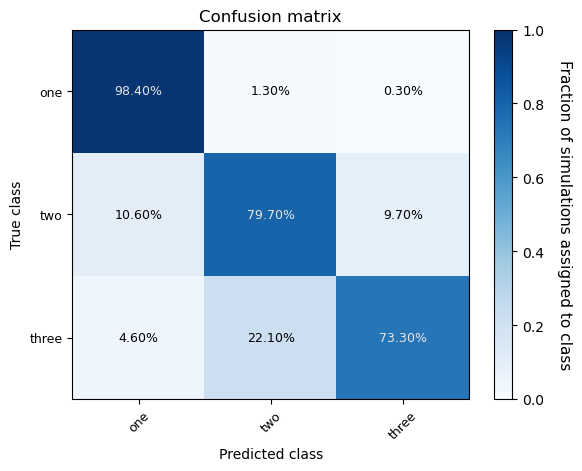

94/94 [==============================] - 0s 3ms/step
[[997   0   3]
 [143 806  51]
 [ 49 103 848]]


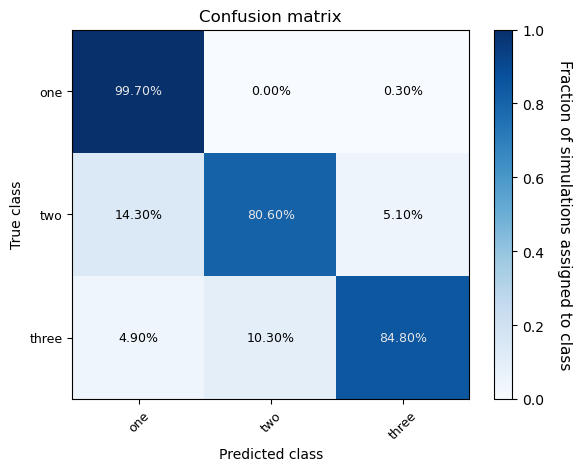

94/94 [==============================] - 0s 3ms/step


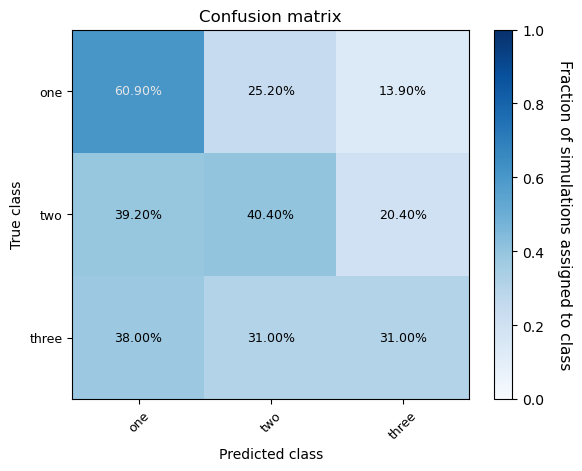

94/94 [==============================] - 1s 5ms/step


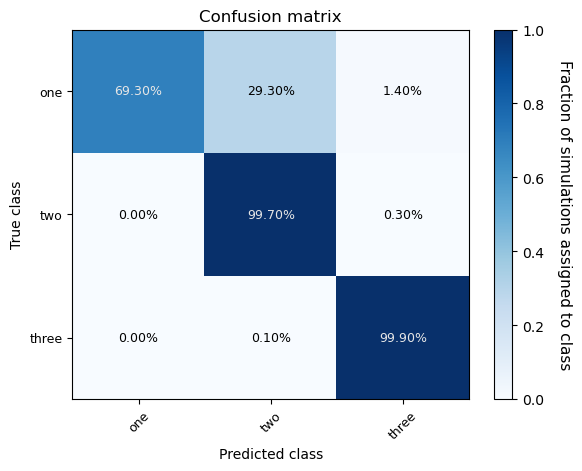

94/94 [==============================] - 1s 6ms/step


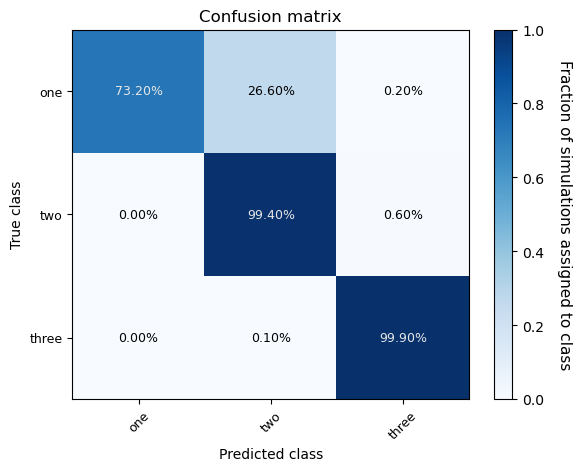

94/94 [==============================] - 1s 6ms/step


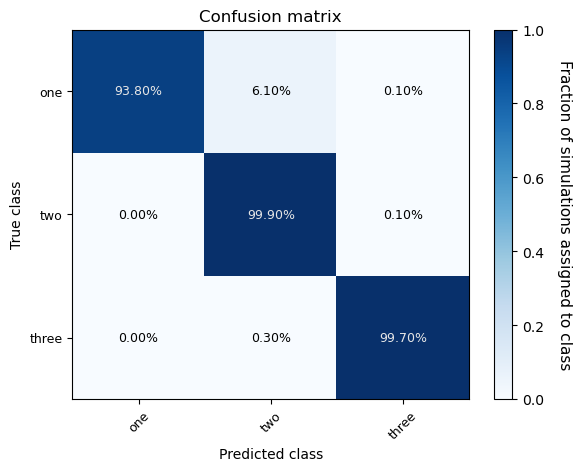

94/94 [==============================] - 1s 6ms/step


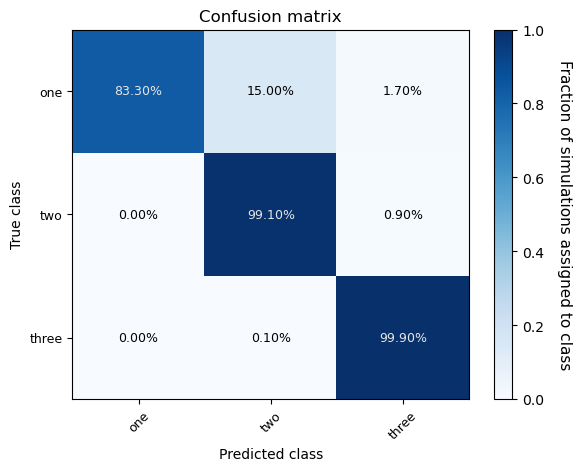

94/94 [==============================] - 1s 6ms/step


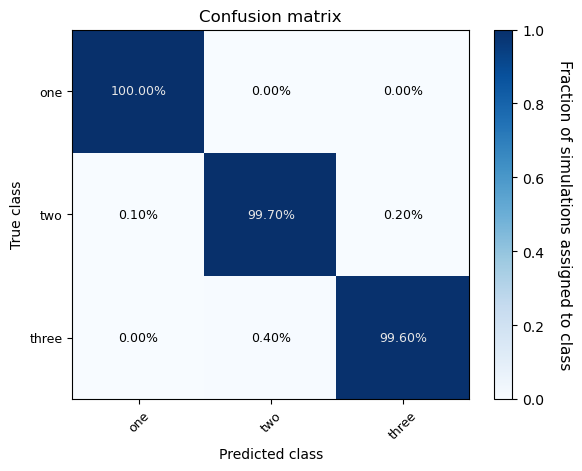

94/94 [==============================] - 1s 6ms/step


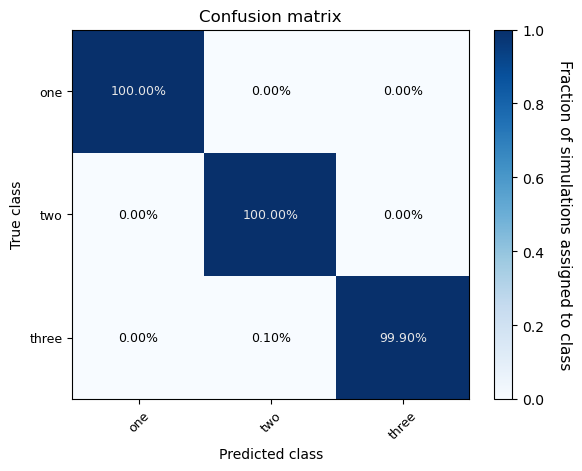

94/94 [==============================] - 1s 6ms/step


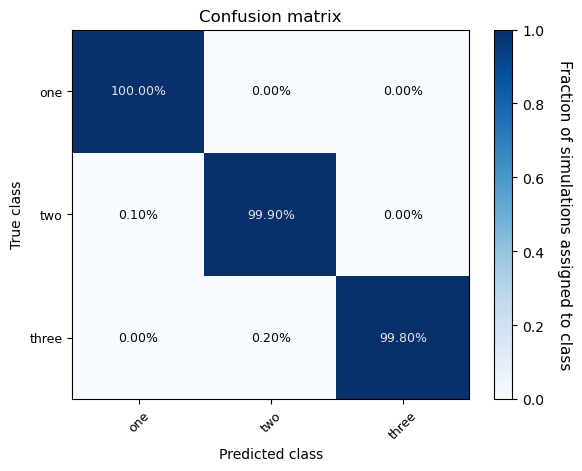

94/94 [==============================] - 0s 3ms/step
[[994   4   2]
 [176 740  84]
 [ 57 159 784]]


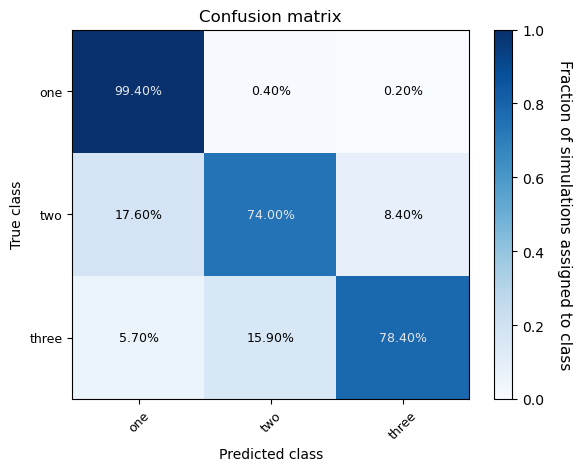

94/94 [==============================] - 0s 3ms/step
[[991   6   3]
 [198 733  69]
 [ 51 109 840]]


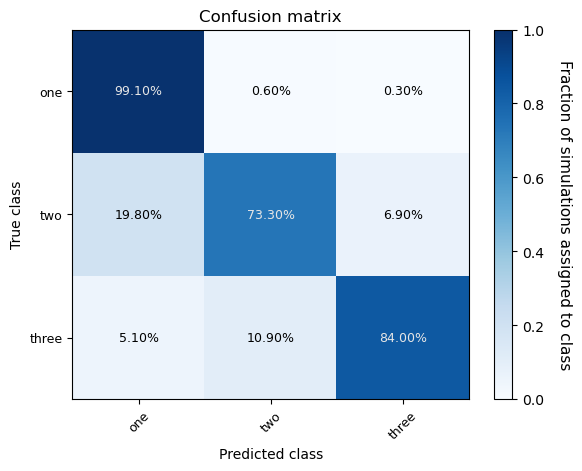

94/94 [==============================] - 0s 3ms/step


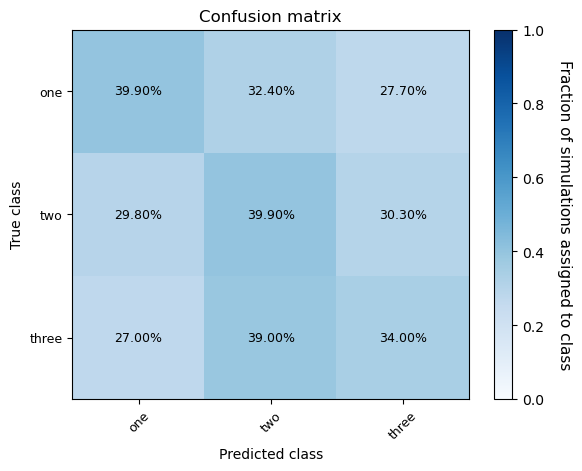

94/94 [==============================] - 1s 5ms/step


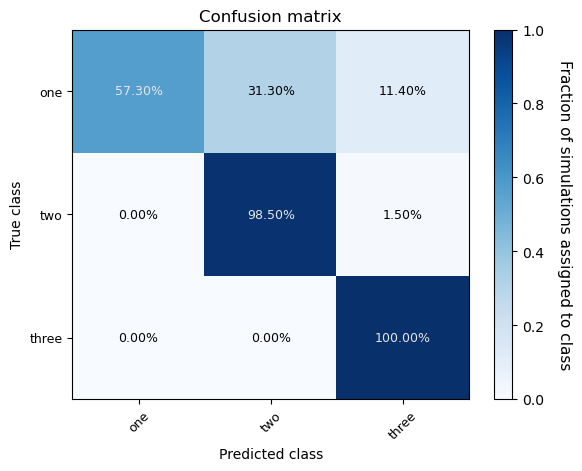

94/94 [==============================] - 1s 6ms/step


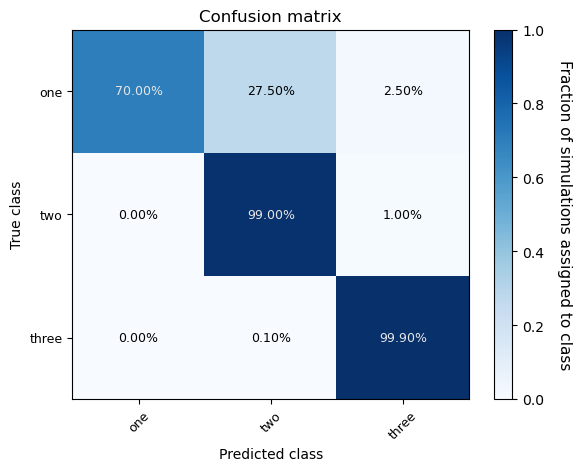

94/94 [==============================] - 1s 6ms/step


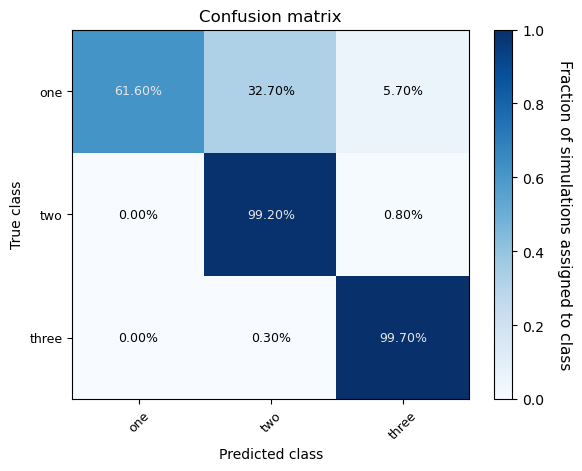

94/94 [==============================] - 1s 5ms/step


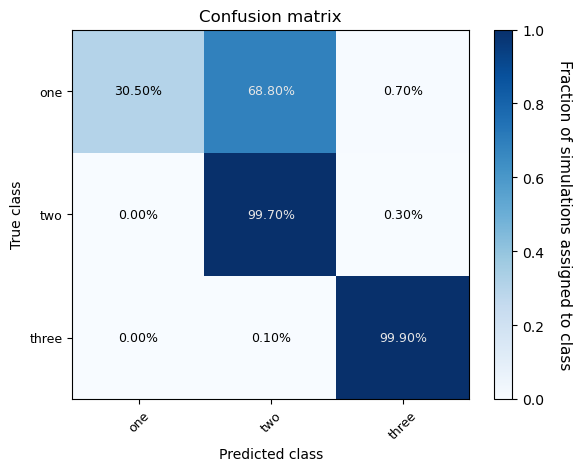

94/94 [==============================] - 1s 6ms/step


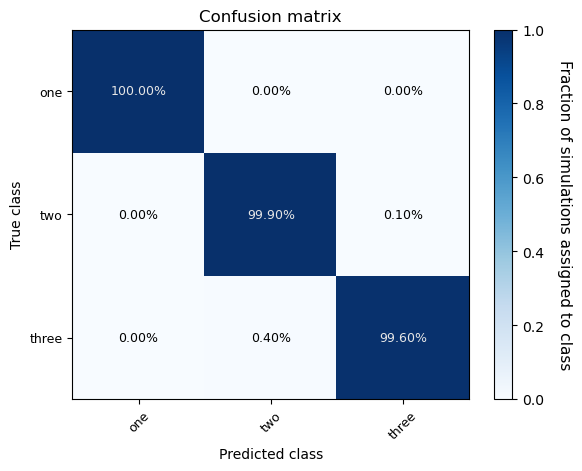

94/94 [==============================] - 1s 6ms/step


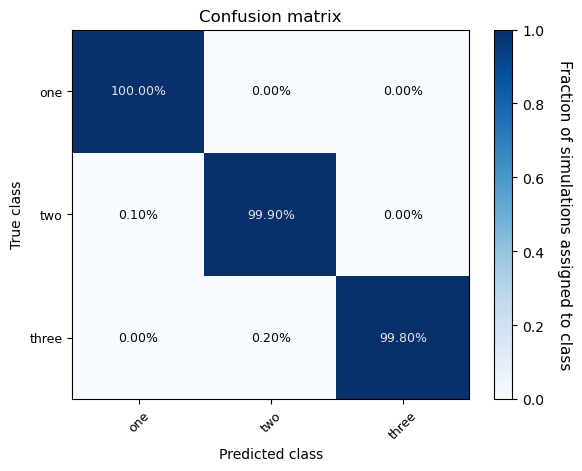

94/94 [==============================] - 1s 6ms/step


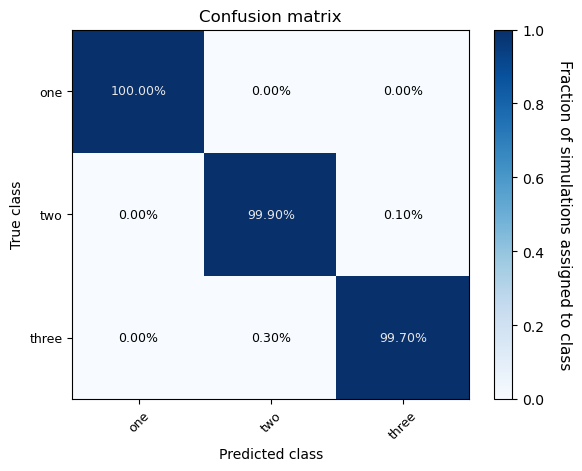

94/94 [==============================] - 0s 3ms/step
[[982  14   4]
 [133 669 198]
 [ 89 287 624]]


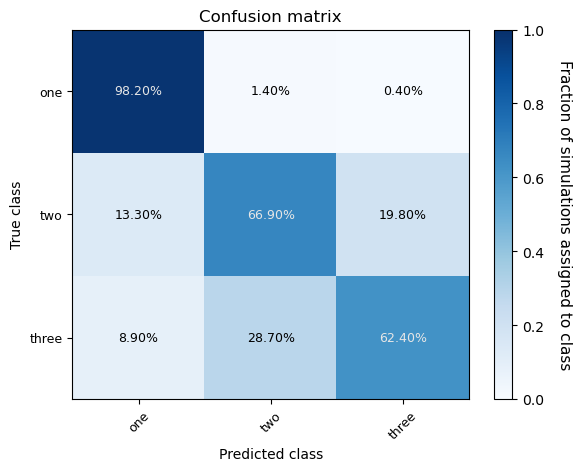

94/94 [==============================] - 0s 3ms/step
[[983  10   7]
 [201 668 131]
 [ 91 170 739]]


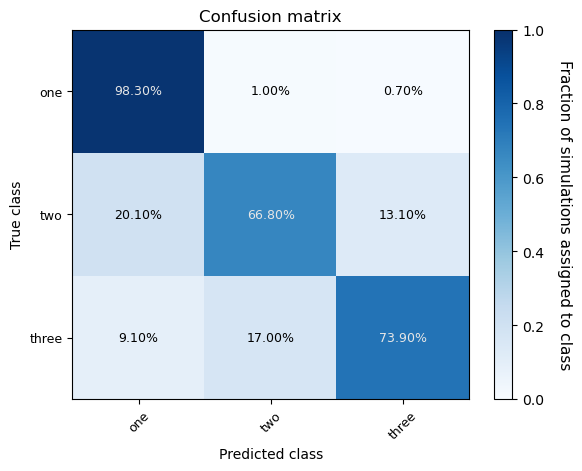

94/94 [==============================] - 0s 3ms/step


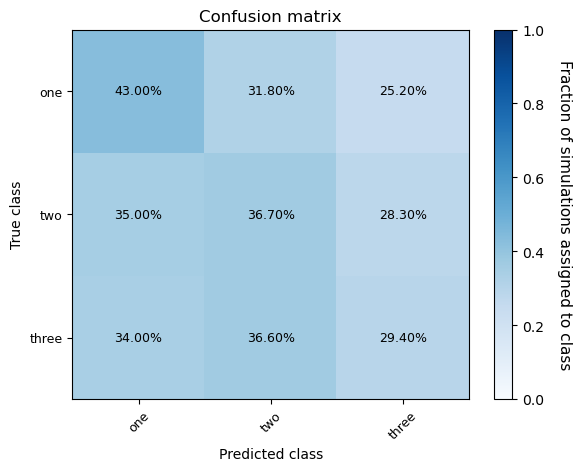

94/94 [==============================] - 1s 5ms/step


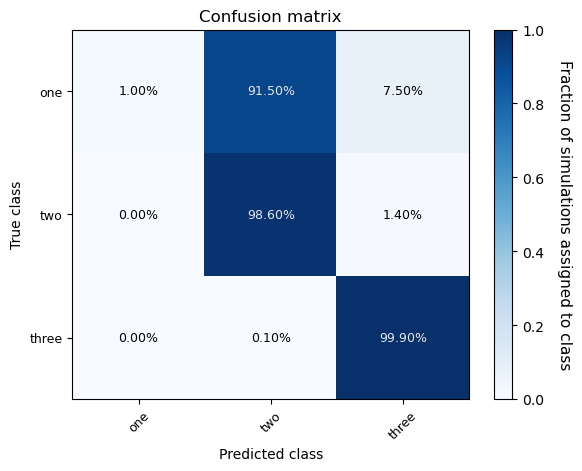

94/94 [==============================] - 1s 6ms/step


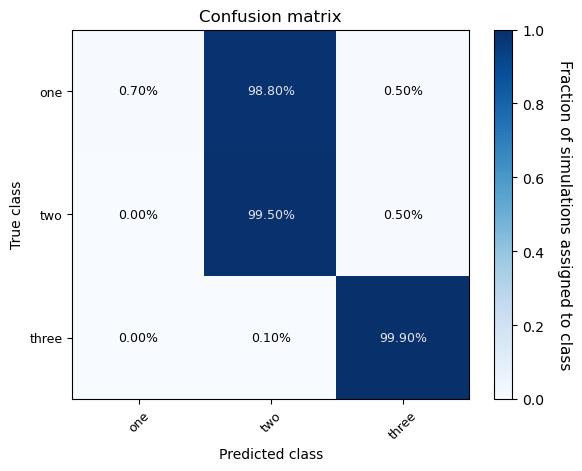

94/94 [==============================] - 1s 6ms/step


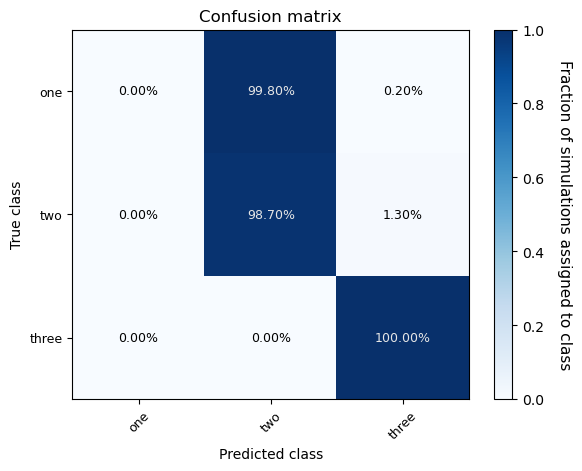

94/94 [==============================] - 1s 6ms/step


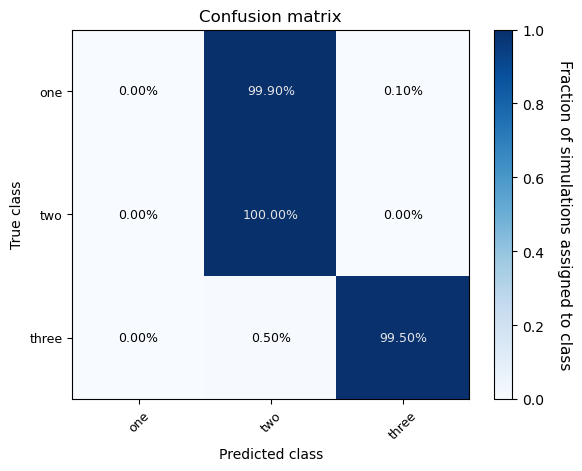

94/94 [==============================] - 1s 6ms/step


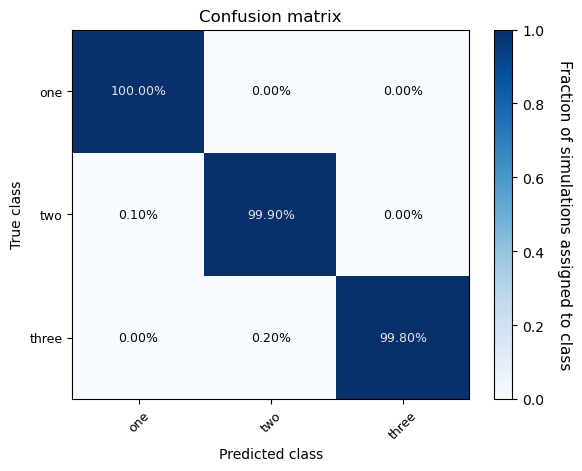

94/94 [==============================] - 1s 6ms/step


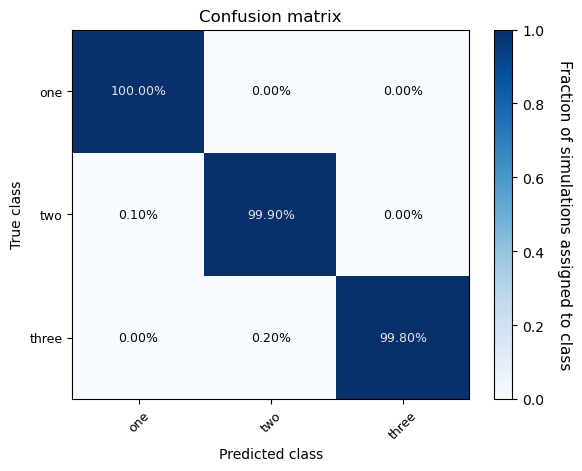

94/94 [==============================] - 1s 6ms/step


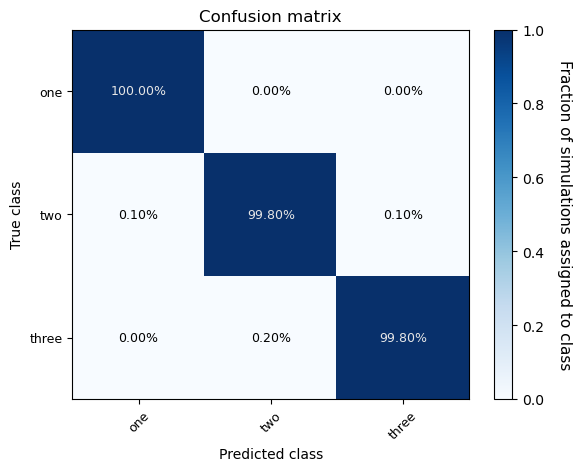

In [13]:
#here's the confusion matrix function
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    
#now the actual work #1
#first get the predictions
pred = model1.predict(traits_BM20.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
pred = model2.predict(traits_OU20.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model3.predict(traits_discrete20.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model4.predict(xtest20)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model5.predict([traits_BM.reshape(3000,-1), xtest20])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model6.predict([traits_OU.reshape(3000,-1), xtest20])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model7.predict([traits_discrete.reshape(3000,-1), xtest20])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model8.predict([traits_BM20.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model9.predict([traits_OU20.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model10.predict([traits_discrete20.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model11.predict(traits_BM40.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model12.predict(traits_OU40.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model13.predict(traits_discrete40.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model14.predict(xtest40)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model15.predict([traits_BM.reshape(3000,-1), xtest40])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model16.predict([traits_OU.reshape(3000,-1), xtest40])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model17.predict([traits_discrete.reshape(3000,-1), xtest40])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model18.predict([traits_BM40.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model19.predict([traits_OU40.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model20.predict([traits_discrete40.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #1
#first get the predictions
#pred = model1.predict(traits_BM[:int(len(y)*.25)].reshape(1000,-1))
pred = model21.predict(traits_BM60.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]
print (confusion_matrix(ytest, pred_cat))

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()
classOrderLs=['one','two','three']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #2
#first get the predictions
#pred = model2.predict(traits_BM50[:int(len(y)*.25)].reshape(1000,-1))
pred = model22.predict(traits_OU60.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
print (confusion_matrix(ytest, pred_cat))
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #3
#first get the predictions
pred = model23.predict(traits_discrete60.reshape(3000,-1))
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #4
#first get the predictions
pred = model24.predict(xtest60)
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model25.predict([traits_BM.reshape(3000,-1), xtest60])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model26.predict([traits_OU.reshape(3000,-1), xtest60])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model27.predict([traits_discrete.reshape(3000,-1), xtest60])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #5
#first get the predictions
pred = model28.predict([traits_BM60.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #6
#first get the predictions
pred = model29.predict([traits_OU60.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

#now the actual work #7
#first get the predictions
pred = model30.predict([traits_discrete60.reshape(3000,-1), xtest])
pred_cat = [i.argmax() for i in pred]
ytest_cat = [i.argmax() for i in ytest]

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(ytest_cat)):
    counts[ytest[i]][pred_cat[i]] += 1
counts.reverse()

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()